In [2]:
# !pip install imblearn

    100% |████████████████████████████████| 153kB 7.0MB/s ta 0:00:01
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import imblearn.over_sampling
import seaborn as sns
sns.set()
%matplotlib inline
plt.style.use('fivethirtyeight')


In [4]:
orders_products_dtype={
    'order_id': np.int32, 
    'product_id': np.int32,
    'add_to_cart_order': np.int16,
    'reordered': np.int8
}

orders_products_prior_df = pd.read_csv('./data/order_products__prior.csv', dtype=orders_products_dtype)
orders_products_train_df = pd.read_csv('./data/order_products__train.csv', dtype=orders_products_dtype)

orders_dtype = {
    'order_id': np.int32,
    'user_id': np.int32,
    'order_number': np.int16,
    'order_dow': np.int8,
    'order_hour_of_day': np.int8,
    'days_since_prior_order': np.float16
}
orders_df = pd.read_csv('./data/orders.csv', dtype=orders_dtype)

aisles_dtype = {
    'aisle_id': np.int16
}
aisles_df = pd.read_csv('./data/aisles.csv', dtype=aisles_dtype)

departments_dtype={
    'department_id': np.int8
}
departments_df = pd.read_csv('./data/departments.csv', dtype=departments_dtype)

products_dtype = {
    'product_id': np.int32,
    'aisle_id': np.int16,
    'department_id': np.int8
}
products_df = pd.read_csv('./data/products.csv', dtype=products_dtype)

# Data Joining

In [5]:
# Get all unique user_id in train set where current basket exists
orders_products_train_df = orders_products_train_df.merge(orders_df.drop(['eval_set'], axis=1), on='order_id')
unique_current_user_ids = orders_products_train_df.user_id.unique()

In [6]:
# Create column in PRIOR to track if user has a current order
orders_products_prior_df = orders_products_prior_df.merge(orders_df.drop(['eval_set'], axis=1), on='order_id')
orders_products_prior_df['has_current_order'] = orders_products_prior_df['user_id'].isin(unique_current_user_ids)

# Keep only rows where user has current basket
orders_products_prior_filtered_df = orders_products_prior_df[orders_products_prior_df['has_current_order']].drop(['has_current_order'], axis=1)

# Feature Engineering

In [7]:
# USER PRODUCT FEATURES
from collections import OrderedDict
from itertools import groupby
# user_product_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_X = (orders_products_prior_df.groupby(['user_id', 'product_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id','nunique'),
                                                    ('add_to_cart_order', 'median'),
                                                    ('order_hour_of_day','mean'),
                                                    ('days_since_prior_order','mean'),
                                                    ('reordered', (lambda x: tuple(x)))]
                                           )))

df_X.columns = ['user_id', 'product_id', 'user_product_times_ordered', 'user_product_add_to_cart_order_median', 'user_product_hour_of_day_mean', 'user_product_average_days_since_prior_order', 'reordered_history'] 


### Calculate whether last time reordered and longest reorder streak

In [8]:

df_X['last_reorder'] = df_X['reordered_history'].map(lambda x: x[-1])
def find_max_reorders(reorder_tuple):
    count_dups = [len(list(group)) for k, group in groupby(reorder_tuple) if k]
    try:
        return max(count_dups)
    except: 
        return 0
df_X['max_consec_reorders'] = df_X['reordered_history'].map(find_max_reorders)


In [9]:
df_X.drop(['reordered_history'], axis=1, inplace=True)

## Apply Training Label Column

In [10]:
# Apply Training Label Column
train_carts = (orders_products_train_df.groupby('user_id',as_index=False)
                                      .agg({'product_id':(lambda x: set(x))})
                                      .rename(columns={'product_id':'latest_cart'}))
df_X = df_X.merge(train_carts, on='user_id')
df_X['in_cart'] = (df_X.apply(lambda row: row['product_id'] in row['latest_cart'], axis=1).astype(int))

In [27]:
df_prior = pd.read_csv('./data/order_products__prior.csv', dtype=orders_products_dtype)

In [28]:
df_train = pd.read_csv('./data/order_products__train.csv', dtype=orders_products_dtype)

In [17]:
df_temp = pd.read_csv('./data/orders.csv', dtype=orders_dtype)

In [29]:
df_temp.head(5)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [52]:
df_temp[df_temp['eval_set'] == 'test']['user_id'].unique()[:20]

array([ 3,  4,  6, 11, 12, 15, 16, 19, 20, 22, 25, 26, 28, 31, 32, 33, 35,
       36, 39, 40])

In [53]:
df_temp[df_temp['eval_set'] == 'train']['user_id'].unique()[:20]

array([ 1,  2,  5,  7,  8,  9, 10, 13, 14, 17, 18, 21, 23, 24, 27, 29, 30,
       34, 37, 38])

In [54]:
df_temp[df_temp['eval_set'] == 'prior']['user_id'].unique()[:20]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [26]:
df_temp[df_temp['eval_set'] == 'test'].sort_values('order_id').head(10)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
611292,17,36855,test,5,6,15,1.0
584613,34,35220,test,20,3,11,8.0
3102779,137,187107,test,9,2,19,30.0
1929637,182,115892,test,28,0,11,8.0
590591,257,35581,test,9,6,23,5.0
1888538,313,113359,test,31,6,22,7.0
2880687,353,173814,test,4,4,13,30.0
924638,386,55492,test,8,0,15,30.0
2009806,414,120775,test,18,5,14,8.0
556925,418,33565,test,12,0,12,14.0


In [55]:
pd.read_csv('./data/sample_submission.csv', dtype=orders_products_dtype).head()

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [63]:
print(df_temp[df_temp['user_id'] == 1])
print(df_temp[df_temp['user_id'] == 2])
print(df_temp[df_temp['user_id'] == 3])
print(df_temp[df_temp['user_id'] == 4])

    order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0    2539329        1    prior             1          2                  8   
1    2398795        1    prior             2          3                  7   
2     473747        1    prior             3          3                 12   
3    2254736        1    prior             4          4                  7   
4     431534        1    prior             5          4                 15   
5    3367565        1    prior             6          2                  7   
6     550135        1    prior             7          1                  9   
7    3108588        1    prior             8          1                 14   
8    2295261        1    prior             9          1                 16   
9    2550362        1    prior            10          4                  8   
10   1187899        1    train            11          4                  8   

    days_since_prior_order  
0                      NaN  
1    

In [65]:
df_train[df_train['order_id'] == 1492625].head()

,order_id,product_id,add_to_cart_order,reordered
606747,1492625,22963,1,1
606748,1492625,7963,2,1
606749,1492625,16589,3,1
606750,1492625,32792,4,1
606751,1492625,41787,5,1


In [71]:
df_prior[df_prior['order_id'] == 1374495].head()


,order_id,product_id,add_to_cart_order,reordered
13022418,1374495,9387,1,0
13022419,1374495,17668,2,0
13022420,1374495,15143,3,0
13022421,1374495,16797,4,0
13022422,1374495,39190,5,0


In [73]:
df_prior[df_prior['order_id'] == 444309].head()


,order_id,product_id,add_to_cart_order,reordered
4210776,444309,38596,1,0
4210777,444309,21903,2,1
4210778,444309,248,3,0
4210779,444309,40604,4,0
4210780,444309,8021,5,0


In [74]:
df_prior[df_prior['order_id'] == 3002854].head()

,order_id,product_id,add_to_cart_order,reordered
28473202,3002854,39190,1,1
28473203,3002854,47766,2,1
28473204,3002854,21903,3,1
28473205,3002854,49683,4,0
28473206,3002854,28373,5,0


## More (User Specific) Features...

In [10]:
# USER FEATURES
from collections import OrderedDict

user_features = ['user_total_orders','user_avg_cartsize','user_total_products','user_avg_days_since_prior_order']

df_user_features = (orders_products_prior_df.groupby(['user_id'],as_index=False)
                                           .agg(OrderedDict(
                                                   [('order_id',['nunique', (lambda x: x.shape[0] / x.nunique())]),
                                                    ('product_id','nunique'),
                                                    ('days_since_prior_order','mean')]
                                           )))

df_user_features.columns = ['user_id'] + user_features
# df_user_features.head()

In [11]:
# Merge user feature columns
df_X = df_X.merge(df_user_features, on=['user_id'])

### Data Cleaning

Text(0.5,1,'Number of NaN values per feature')

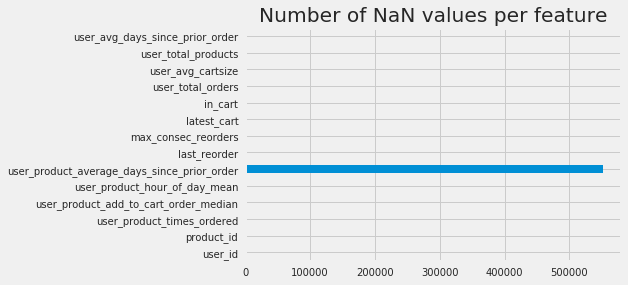

In [12]:
df_X.isnull().sum().plot(kind='barh')
plt.title('Number of NaN values per feature')

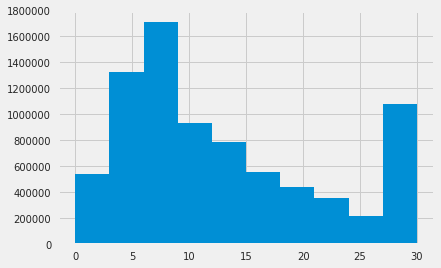

In [13]:
df_X['user_product_average_days_since_prior_order'].hist();

### Create Bins for `user_product_average_days_since_prior_order`

In [14]:
def convert_to_bin(x):
    if x < 5:
        return 0
    elif x < 10:
        return 1
    elif x < 15:
        return 2
    elif x < 20:
        return 3
    elif x < 25:
        return 4
    elif x <= 30:
        return 5
    else:
        return 6

mapped_df = df_X['user_product_average_days_since_prior_order'].map(convert_to_bin)
up_adspo_bins = pd.get_dummies(mapped_df)
up_adspo_bins.columns = ['usadspo_0-5', 'usadspo_5-10', 'usadspo_10-15', 'usadspo_15-20', 'usadspo_20-25', 'usadspo_25-30', 'usadspo_firstTime']
df_X = pd.concat([df_X, up_adspo_bins], axis=1)
# df_X.drop(['user_product_average_days_since_prior_order'], axis=1, inplace=True)

Text(0.5,0,'Order Count')

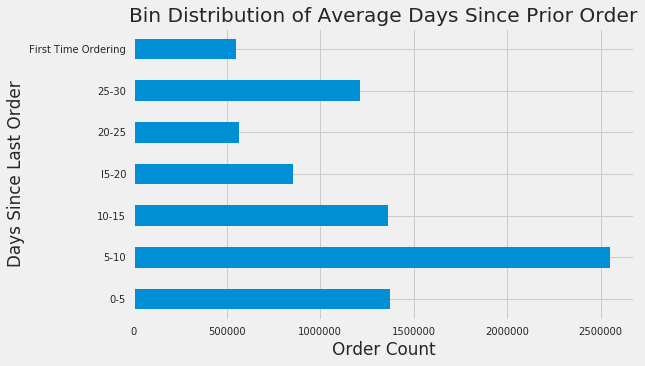

In [18]:
plot_labels = ['usadspo_0-5', 'usadspo_5-10', 'usadspo_10-15', 
         'usadspo_15-20', 'usadspo_20-25', 'usadspo_25-30', 
         'usadspo_firstTime']
plt.figure(figsize=(8,5))
df_X[plot_labels].apply('sum', axis=0).plot(kind='barh');
plt.title('Bin Distribution of Average Days Since Prior Order')
plt.yticks(np.arange(len(plot_labels)), ['0-5', '5-10', '10-15', 'l5-20', '20-25','25-30', 'First Time Ordering'])
plt.ylabel('Days Since Last Order')
plt.xlabel('Order Count')


## Product Detail Features

In [19]:
# Create Feature Dataframe for Products
products_df = products_df.merge(departments_df, on='department_id').merge(aisles_df, on='aisle_id').drop(['product_name','aisle_id','department_id'], axis=1)
products_df_departments = pd.concat([products_df, pd.get_dummies(products_df['department'])], axis=1).drop(['department','aisle'], axis=1)
products_df_aisles = pd.concat([products_df, pd.get_dummies(products_df['aisle'])], axis=1).drop(['department','aisle'], axis=1)

In [20]:
# Merge department feature columns
df_X = df_X.merge(products_df_departments, on=['product_id'])
# Merge aisle feature columns
df_X = df_X.merge(products_df_aisles, on=['product_id'])

# Data Subsetting

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix,accuracy_score, recall_score

In [22]:
# CREATE SUBSET OF USERS
np.random.seed(153)
total_users = df_X['user_id'].unique() 
user_subset = np.random.choice(total_users, size=int(total_users.shape[0] * .05), replace=False)

df_subset = df_X[df_X['user_id'].isin(user_subset)] 


### Randomized Train Test Split with subset

In [23]:
# Generate test train split with subset 70/30
np.random.seed(48)
subset_total_users = df_subset['user_id'].unique() 
test_set = np.random.choice(subset_total_users, size=int(subset_total_users.shape[0] * .30), replace=False)

df_X_tr, df_X_te = df_subset[~df_subset['user_id'].isin(test_set)], df_subset[df_subset['user_id'].isin(test_set)] 


([<matplotlib.axis.YTick at 0x7f27dd76ec18>,
 <a list of 2 Text yticklabel objects>)

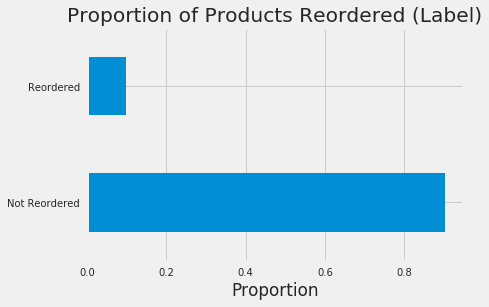

In [24]:
# Check weights
df_X.in_cart.value_counts(normalize=True).plot(kind='barh');
plt.title('Proportion of Products Reordered (Label)')
plt.xlabel('Proportion')
plt.yticks([0,1], ['Not Reordered', 'Reordered'])

In [25]:
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler

# Logistic Regression with one feature

In [26]:
# Create training with single feature
feature_columns = ['user_total_orders']
y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr[feature_columns], \
             df_X_te[feature_columns]


### Scaling Data for Regression

In [27]:
# Scale Data
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

In [28]:
lr = LogisticRegression()
lr.fit(X_tr, y_tr)
print('Simple Logistic Regression; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr.predict(X_te), y_te), roc_auc_score(y_te, lr.predict_proba(X_te)[:,1]))) 


# Oversample positive samples to be 40% of targets 
ROS = imblearn.over_sampling.RandomOverSampler(random_state=159)
X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

lr_os = LogisticRegression() 
lr_os.fit(X_tr_rs, y_tr_rs)

print('Logistic Regression on Oversampled Train Data; Test F1: %.3f, Test AUC: %.3f' % \
      (f1_score(lr_os.predict(X_te), y_te), roc_auc_score(y_te, lr_os.predict_proba(X_te)[:,1])))


/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


Simple Logistic Regression; Test F1: 0.000, Test AUC: 0.598
Logistic Regression on Oversampled Train Data; Test F1: 0.201, Test AUC: 0.598


In [29]:
all_features = [
    'user_product_times_ordered',
    'user_product_add_to_cart_order_median',
    'user_product_hour_of_day_mean',
    'user_total_orders',
    'user_avg_cartsize',
    'user_total_products',
    'user_avg_days_since_prior_order', 
    ['usadspo_0-5', 'usadspo_5-10', 'usadspo_10-15', 
         'usadspo_15-20', 'usadspo_20-25', 'usadspo_25-30', 
         'usadspo_firstTime'],
    'last_reorder',
    'max_consec_reorders',
    ['alcohol', 'babies', 'bakery', 'beverages',
        'breakfast', 'bulk', 'canned goods', 'dairy eggs', 'deli',
        'dry goods pasta', 'frozen', 'household', 'international',
        'meat seafood', 'pantry', 'personal care', 'pets',
        'produce', 'snacks'],
    ['air fresheners candles', 'asian foods', 
    'baby accessories', 'baby bath body care', 
    'baby food formula', 'bakery desserts', 
    'baking ingredients', 'baking supplies decor', 
    'beauty', 'beers coolers', 'body lotions soap', 
    'bread', 'breakfast bakery', 'breakfast bars pastries', 
    'bulk dried fruits vegetables', 'bulk grains rice dried goods', 
    'buns rolls', 'butter', 'candy chocolate', 
    'canned fruit applesauce', 'canned jarred vegetables', 
    'canned meals beans', 'canned meat seafood', 
    'cat food care', 'cereal', 'chips pretzels', 
    'cleaning products', 'cocoa drink mixes', 
    'coffee', 'cold flu allergy', 'condiments', 
    'cookies cakes', 'crackers', 'cream', 'deodorants', 
    'diapers wipes', 'digestion', 'dish detergents', 
    'dog food care', 'doughs gelatins bake mixes', 
    'dry pasta', 'eggs', 'energy granola bars', 
    'energy sports drinks', 'eye ear care', 
    'facial care', 'feminine care', 'first aid', 
    'food storage', 'fresh dips tapenades', 
    'fresh fruits', 'fresh herbs', 'fresh pasta', 
    'fresh vegetables', 'frozen appetizers sides', 
    'frozen breads doughs', 'frozen breakfast', 
    'frozen dessert', 'frozen juice', 'frozen meals', 
    'frozen meat seafood', 'frozen pizza', 
    'frozen produce', 'frozen vegan vegetarian', 
    'fruit vegetable snacks', 'grains rice dried goods', 
    'granola', 'hair care', 'honeys syrups nectars', 
    'hot cereal pancake mixes', 'hot dogs bacon sausage', 
    'ice cream ice', 'ice cream toppings', 'indian foods', 
    'instant foods', 'juice nectars', 'kitchen supplies', 
    'kosher foods', 'latino foods', 'laundry', 
    'lunch meat', 'marinades meat preparation', 
    'meat counter', 'milk', 'mint gum', 'missing_y', 
    'more household', 'muscles joints pain relief', 
    'nuts seeds dried fruit', 'oils vinegars', 
    'oral hygiene', 'other_y', 'other creams cheeses', 
    'packaged cheese', 'packaged meat', 'packaged poultry', 
    'packaged produce', 'packaged seafood', 
    'packaged vegetables fruits', 'paper goods', 
    'pasta sauce', 'pickled goods olives', 
    'plates bowls cups flatware', 'popcorn jerky', 
    'poultry counter', 'prepared meals', 'prepared soups salads', 
    'preserved dips spreads', 'protein meal replacements', 
    'red wines', 'refrigerated', 'refrigerated pudding desserts', 
    'salad dressing toppings', 'seafood counter', 
    'shave needs', 'skin care', 'soap', 'soft drinks', 
    'soup broth bouillon', 'soy lactosefree', 
    'specialty cheeses', 'specialty wines champagnes', 
    'spices seasonings', 'spirits', 'spreads', 'tea', 
    'tofu meat alternatives', 'tortillas flat bread', 
    'trail mix snack mix', 'trash bags liners', 
    'vitamins supplements', 'water seltzer sparkling water', 
    'white wines', 'yogurt']
]

In [30]:
f1_scores = []
for i in range(len(all_features)):
    if isinstance(all_features[i], str):
        feature_columns = [all_features[i]]
    elif isinstance(all_features[i], list):
        feature_columns = all_features[i]
    y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
    X_tr, X_te = df_X_tr[feature_columns], \
                 df_X_te[feature_columns]

    scaler = StandardScaler()
    X_tr = scaler.fit_transform(X_tr)
    X_te = scaler.transform(X_te)

    # oversample positive samples to be 40% of targets 
    ROS = imblearn.over_sampling.RandomOverSampler(random_state=159)
    X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

    lr = LogisticRegression()
    lr.fit(X_tr_rs, y_tr_rs)
    f1_scr = f1_score(lr.predict(X_te), y_te)
#     print('Features used: {}'.format(feature_columns))
#     print('F1 Score: {}'.format(f1_scr))
    f1_scores.append(f1_scr)

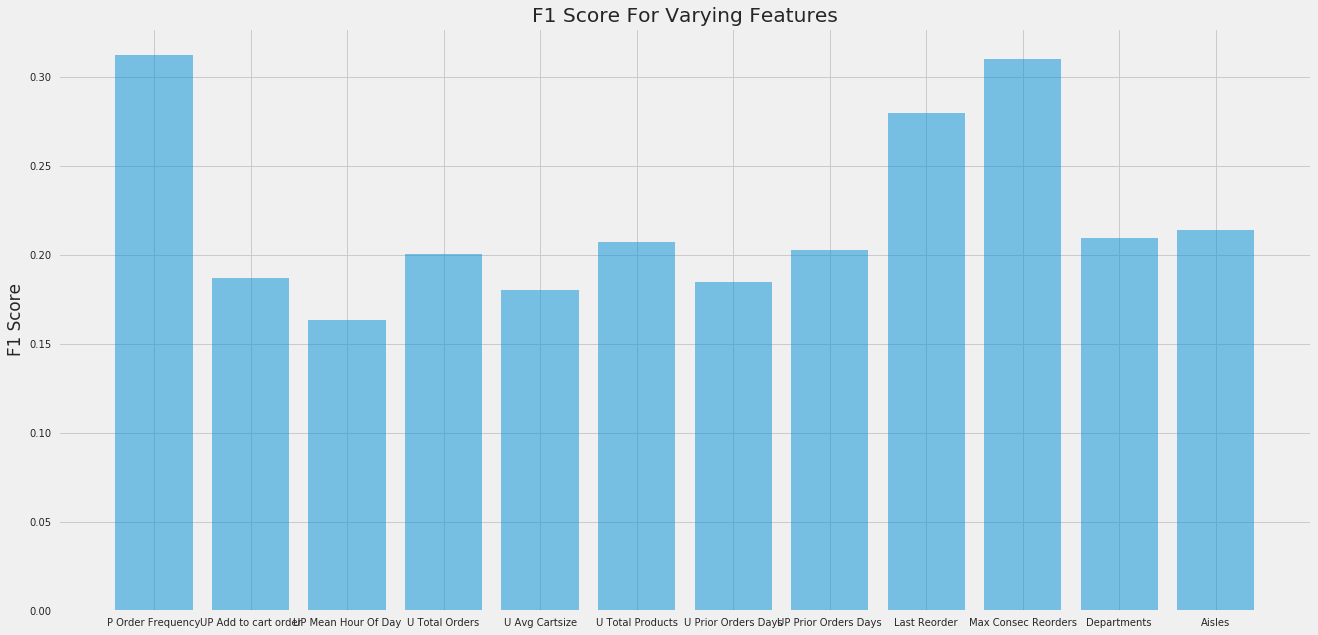

In [31]:
x_labels = [
    'P Order Frequency',
    'UP Add to cart order',
    'UP Mean Hour Of Day',
    'U Total Orders',
    'U Avg Cartsize',
    'U Total Products',
    'U Prior Orders Days', 
    'UP Prior Orders Days',
    'Last Reorder',
    'Max Consec Reorders',
    'Departments',
    'Aisles'
]

y_pos = np.arange(len(x_labels))
plt.figure(figsize=(20,10))

plt.bar(y_pos, f1_scores, align='center', alpha=0.5)

plt.xticks(y_pos, x_labels)
plt.ylabel('F1 Score')
plt.title('F1 Score For Varying Features')

# plt.bar(x_labels, f1_scores)
# plt.xticks(x_labels)
plt.show()

In [32]:
sorted(list(zip(x_labels, f1_scores)), key=lambda x: x[1], reverse=True)

[('P Order Frequency', 0.31194884693475561),
 ('Max Consec Reorders', 0.31012802060449962),
 ('Last Reorder', 0.27984323694523883),
 ('Aisles', 0.21365213050545906),
 ('Departments', 0.20929703495867141),
 ('U Total Products', 0.20692489724747787),
 ('UP Prior Orders Days', 0.20253808541307486),
 ('U Total Orders', 0.20064470851324509),
 ('UP Add to cart order', 0.18683408992776368),
 ('U Prior Orders Days', 0.18466638499788748),
 ('U Avg Cartsize', 0.1800085096036956),
 ('UP Mean Hour Of Day', 0.1632096896290689)]

In [33]:
all_log_features = [
    'user_product_times_ordered',
    'user_product_add_to_cart_order_median',
    'user_product_hour_of_day_mean',
    'user_total_orders',
    'user_avg_cartsize',
    'user_total_products',
#     'user_avg_days_since_prior_order', 
    'usadspo_0-5', 'usadspo_5-10', 'usadspo_10-15', 
         'usadspo_15-20', 'usadspo_20-25', 'usadspo_25-30', 
         'usadspo_firstTime',
    'last_reorder',
    'max_consec_reorders',
    'alcohol', 'babies', 'bakery', 'beverages',
        'breakfast', 'bulk', 'canned goods', 'dairy eggs', 'deli',
        'dry goods pasta', 'frozen', 'household', 'international',
        'meat seafood', 'pantry', 'personal care', 'pets',
        'produce', 'snacks',
    'air fresheners candles', 'asian foods', 
        'baby accessories', 'baby bath body care', 
        'baby food formula', 'bakery desserts', 
        'baking ingredients', 'baking supplies decor', 
        'beauty', 'beers coolers', 'body lotions soap', 
        'bread', 'breakfast bakery', 'breakfast bars pastries', 
        'bulk dried fruits vegetables', 'bulk grains rice dried goods', 
        'buns rolls', 'butter', 'candy chocolate', 
        'canned fruit applesauce', 'canned jarred vegetables', 
        'canned meals beans', 'canned meat seafood', 
        'cat food care', 'cereal', 'chips pretzels', 
        'cleaning products', 'cocoa drink mixes', 
        'coffee', 'cold flu allergy', 'condiments', 
        'cookies cakes', 'crackers', 'cream', 'deodorants', 
        'diapers wipes', 'digestion', 'dish detergents', 
        'dog food care', 'doughs gelatins bake mixes', 
        'dry pasta', 'eggs', 'energy granola bars', 
        'energy sports drinks', 'eye ear care', 
        'facial care', 'feminine care', 'first aid', 
        'food storage', 'fresh dips tapenades', 
        'fresh fruits', 'fresh herbs', 'fresh pasta', 
        'fresh vegetables', 'frozen appetizers sides', 
        'frozen breads doughs', 'frozen breakfast', 
        'frozen dessert', 'frozen juice', 'frozen meals', 
        'frozen meat seafood', 'frozen pizza', 
        'frozen produce', 'frozen vegan vegetarian', 
        'fruit vegetable snacks', 'grains rice dried goods', 
        'granola', 'hair care', 'honeys syrups nectars', 
        'hot cereal pancake mixes', 'hot dogs bacon sausage', 
        'ice cream ice', 'ice cream toppings', 'indian foods', 
        'instant foods', 'juice nectars', 'kitchen supplies', 
        'kosher foods', 'latino foods', 'laundry', 
        'lunch meat', 'marinades meat preparation', 
        'meat counter', 'milk', 'mint gum', 'missing_y', 
        'more household', 'muscles joints pain relief', 
        'nuts seeds dried fruit', 'oils vinegars', 
        'oral hygiene', 'other_y', 'other creams cheeses', 
        'packaged cheese', 'packaged meat', 'packaged poultry', 
        'packaged produce', 'packaged seafood', 
        'packaged vegetables fruits', 'paper goods', 
        'pasta sauce', 'pickled goods olives', 
        'plates bowls cups flatware', 'popcorn jerky', 
        'poultry counter', 'prepared meals', 'prepared soups salads', 
        'preserved dips spreads', 'protein meal replacements', 
        'red wines', 'refrigerated', 'refrigerated pudding desserts', 
        'salad dressing toppings', 'seafood counter', 
        'shave needs', 'skin care', 'soap', 'soft drinks', 
        'soup broth bouillon', 'soy lactosefree', 
        'specialty cheeses', 'specialty wines champagnes', 
        'spices seasonings', 'spirits', 'spreads', 'tea', 
        'tofu meat alternatives', 'tortillas flat bread', 
        'trail mix snack mix', 'trash bags liners', 
        'vitamins supplements', 'water seltzer sparkling water', 
        'white wines', 'yogurt'
]

In [34]:
y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr[all_log_features], \
             df_X_te[all_log_features]

scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_te = scaler.transform(X_te)

# oversample positive samples to be 40% of targets 
ROS = imblearn.over_sampling.RandomOverSampler(random_state=159)
X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

lr_af = LogisticRegression(n_jobs=-1)
lr_af.fit(X_tr_rs, y_tr_rs)
f1_scr = f1_score(lr_af.predict(X_te), y_te)
#     print('Features used: {}'.format(feature_columns))
print('F1 Score for All Features: {}'.format(f1_scr))
print('Recall Score for All Features: {}'.format(recall_score(lr_af.predict(X_te), y_te)))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


F1 Score for All Features: 0.32624899659798934
F1 Score for All Features: 0.21422117363586166


In [318]:
pd.DataFrame(sorted(list(zip(lr.coef_[0], all_log_features)), key=lambda x:x[0], reverse=True)[:10])

,0,1
0,0.413161,max_consec_reorders
1,0.312790,user_avg_cartsize
2,0.248632,last_reorder
3,0.215626,user_product_times_ordered
4,0.081017,fresh fruits
5,0.072444,produce
6,0.061491,water seltzer sparkling water
7,0.057450,usadspo_20-25
8,0.051247,milk
9,0.050933,usadspo_15-20


In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf_features = ['user_product_times_ordered',
        'user_product_add_to_cart_order_median',
        'user_product_hour_of_day_mean',
        'user_total_orders', 'user_avg_cartsize', 'user_total_products',
        'user_avg_days_since_prior_order', 'user_product_average_days_since_prior_order','last_reorder', 'max_consec_reorders',
        'alcohol', 'babies', 'bakery', 'beverages',
            'breakfast', 'bulk', 'canned goods', 'dairy eggs', 'deli',
            'dry goods pasta', 'frozen', 'household', 'international',
            'meat seafood', 'pantry', 'personal care', 'pets',
            'produce', 'snacks',
        'air fresheners candles', 'asian foods', 
            'baby accessories', 'baby bath body care', 
            'baby food formula', 'bakery desserts', 
            'baking ingredients', 'baking supplies decor', 
            'beauty', 'beers coolers', 'body lotions soap', 
            'bread', 'breakfast bakery', 'breakfast bars pastries', 
            'bulk dried fruits vegetables', 'bulk grains rice dried goods', 
            'buns rolls', 'butter', 'candy chocolate', 
            'canned fruit applesauce', 'canned jarred vegetables', 
            'canned meals beans', 'canned meat seafood', 
            'cat food care', 'cereal', 'chips pretzels', 
            'cleaning products', 'cocoa drink mixes', 
            'coffee', 'cold flu allergy', 'condiments', 
            'cookies cakes', 'crackers', 'cream', 'deodorants', 
            'diapers wipes', 'digestion', 'dish detergents', 
            'dog food care', 'doughs gelatins bake mixes', 
            'dry pasta', 'eggs', 'energy granola bars', 
            'energy sports drinks', 'eye ear care', 
            'facial care', 'feminine care', 'first aid', 
            'food storage', 'fresh dips tapenades', 
            'fresh fruits', 'fresh herbs', 'fresh pasta', 
            'fresh vegetables', 'frozen appetizers sides', 
            'frozen breads doughs', 'frozen breakfast', 
            'frozen dessert', 'frozen juice', 'frozen meals', 
            'frozen meat seafood', 'frozen pizza', 
            'frozen produce', 'frozen vegan vegetarian', 
            'fruit vegetable snacks', 'grains rice dried goods', 
            'granola', 'hair care', 'honeys syrups nectars', 
            'hot cereal pancake mixes', 'hot dogs bacon sausage', 
            'ice cream ice', 'ice cream toppings', 'indian foods', 
            'instant foods', 'juice nectars', 'kitchen supplies', 
            'kosher foods', 'latino foods', 'laundry', 
            'lunch meat', 'marinades meat preparation', 
            'meat counter', 'milk', 'mint gum', 'missing_y', 
            'more household', 'muscles joints pain relief', 
            'nuts seeds dried fruit', 'oils vinegars', 
            'oral hygiene', 'other_y', 'other creams cheeses', 
            'packaged cheese', 'packaged meat', 'packaged poultry', 
            'packaged produce', 'packaged seafood', 
            'packaged vegetables fruits', 'paper goods', 
            'pasta sauce', 'pickled goods olives', 
            'plates bowls cups flatware', 'popcorn jerky', 
            'poultry counter', 'prepared meals', 'prepared soups salads', 
            'preserved dips spreads', 'protein meal replacements', 
            'red wines', 'refrigerated', 'refrigerated pudding desserts', 
            'salad dressing toppings', 'seafood counter', 
            'shave needs', 'skin care', 'soap', 'soft drinks', 
            'soup broth bouillon', 'soy lactosefree', 
            'specialty cheeses', 'specialty wines champagnes', 
            'spices seasonings', 'spirits', 'spreads', 'tea', 
            'tofu meat alternatives', 'tortillas flat bread', 
            'trail mix snack mix', 'trash bags liners', 
            'vitamins supplements', 'water seltzer sparkling water', 
            'white wines', 'yogurt']

y_tr, y_te = df_X_tr['in_cart'], df_X_te['in_cart']
X_tr, X_te = df_X_tr[rf_features].copy(), \
             df_X_te[rf_features].copy()
X_tr[['user_product_average_days_since_prior_order']]=X_tr[['user_product_average_days_since_prior_order']].fillna(-1)
X_te[['user_product_average_days_since_prior_order']]=X_te[['user_product_average_days_since_prior_order']].fillna(-1)

# oversample positive samples
ROS = imblearn.over_sampling.RandomOverSampler(random_state=159)
X_tr_rs, y_tr_rs = ROS.fit_sample(X_tr, y_tr)

In [41]:
# Convert back to dataframe
X_tr_rs = pd.DataFrame(X_tr_rs)
X_tr_rs.columns=rf_features

In [42]:
# Reset dtypes
temp_dtypes = {
    'user_product_times_ordered': np.int32,
    'user_product_add_to_cart_order_median': np.float32,
    'user_product_hour_of_day_mean': np.float32,
    'user_total_orders': np.int32,
    'user_avg_cartsize': np.float32,
    'user_total_products': np.int32,
    'user_avg_days_since_prior_order': np.float16,
    'user_product_average_days_since_prior_order': np.float16,
    'last_reorder': np.int64,
    'max_consec_reorders': np.int64,
    'alcohol': np.uint8,
    'babies': np.uint8,
    'bakery': np.uint8,
    'beverages': np.uint8,
    'breakfast': np.uint8,
    'bulk': np.uint8,
    'canned goods': np.uint8,
    'dairy eggs': np.uint8,
    'deli': np.uint8,
    'dry goods pasta': np.uint8,
    'frozen': np.uint8,
    'household': np.uint8,
    'international': np.uint8,
    'meat seafood': np.uint8,
#     'missing': np.uint8,
#     'other': np.uint8,
    'pantry': np.uint8,
    'personal care': np.uint8,
    'pets': np.uint8,
    'produce': np.uint8,
    'snacks': np.uint8,
    'air fresheners candles': np.uint8, 'asian foods': np.uint8, 'baby accessories': np.uint8, 'baby bath body care': np.uint8, 'baby food formula': np.uint8, 'bakery desserts': np.uint8, 'baking ingredients': np.uint8, 'baking supplies decor': np.uint8, 'beauty': np.uint8, 'beers coolers': np.uint8, 'body lotions soap': np.uint8, 'bread': np.uint8, 'breakfast bakery': np.uint8, 'breakfast bars pastries': np.uint8, 'bulk dried fruits vegetables': np.uint8, 'bulk grains rice dried goods': np.uint8, 'buns rolls': np.uint8, 'butter': np.uint8, 'candy chocolate': np.uint8, 'canned fruit applesauce': np.uint8, 'canned jarred vegetables': np.uint8, 'canned meals beans': np.uint8, 'canned meat seafood': np.uint8, 'cat food care': np.uint8, 'cereal': np.uint8, 'chips pretzels': np.uint8, 'cleaning products': np.uint8, 'cocoa drink mixes': np.uint8, 'coffee': np.uint8, 'cold flu allergy': np.uint8, 'condiments': np.uint8, 'cookies cakes': np.uint8, 'crackers': np.uint8, 'cream': np.uint8, 'deodorants': np.uint8, 'diapers wipes': np.uint8, 'digestion': np.uint8, 'dish detergents': np.uint8, 'dog food care': np.uint8, 'doughs gelatins bake mixes': np.uint8, 'dry pasta': np.uint8, 'eggs': np.uint8, 'energy granola bars': np.uint8, 'energy sports drinks': np.uint8, 'eye ear care': np.uint8, 'facial care': np.uint8, 'feminine care': np.uint8, 'first aid': np.uint8, 'food storage': np.uint8, 'fresh dips tapenades': np.uint8, 'fresh fruits': np.uint8, 'fresh herbs': np.uint8, 'fresh pasta': np.uint8, 'fresh vegetables': np.uint8, 'frozen appetizers sides': np.uint8, 'frozen breads doughs': np.uint8, 'frozen breakfast': np.uint8, 'frozen dessert': np.uint8, 'frozen juice': np.uint8, 'frozen meals': np.uint8, 'frozen meat seafood': np.uint8, 'frozen pizza': np.uint8, 'frozen produce': np.uint8, 'frozen vegan vegetarian': np.uint8, 'fruit vegetable snacks': np.uint8, 'grains rice dried goods': np.uint8, 'granola': np.uint8, 'hair care': np.uint8, 'honeys syrups nectars': np.uint8, 'hot cereal pancake mixes': np.uint8, 'hot dogs bacon sausage': np.uint8, 'ice cream ice': np.uint8, 'ice cream toppings': np.uint8, 'indian foods': np.uint8, 'instant foods': np.uint8, 'juice nectars': np.uint8, 'kitchen supplies': np.uint8, 'kosher foods': np.uint8, 'latino foods': np.uint8, 'laundry': np.uint8, 'lunch meat': np.uint8, 'marinades meat preparation': np.uint8, 'meat counter': np.uint8, 'milk': np.uint8, 'mint gum': np.uint8, 'missing_y': np.uint8, 'more household': np.uint8, 'muscles joints pain relief': np.uint8, 'nuts seeds dried fruit': np.uint8, 'oils vinegars': np.uint8, 'oral hygiene': np.uint8, 'other_y': np.uint8, 'other creams cheeses': np.uint8, 'packaged cheese': np.uint8, 'packaged meat': np.uint8, 'packaged poultry': np.uint8, 'packaged produce': np.uint8, 'packaged seafood': np.uint8, 'packaged vegetables fruits': np.uint8, 'paper goods': np.uint8, 'pasta sauce': np.uint8, 'pickled goods olives': np.uint8, 'plates bowls cups flatware': np.uint8, 'popcorn jerky': np.uint8, 'poultry counter': np.uint8, 'prepared meals': np.uint8, 'prepared soups salads': np.uint8, 'preserved dips spreads': np.uint8, 'protein meal replacements': np.uint8, 'red wines': np.uint8, 'refrigerated': np.uint8, 'refrigerated pudding desserts': np.uint8, 'salad dressing toppings': np.uint8, 'seafood counter': np.uint8, 'shave needs': np.uint8, 'skin care': np.uint8, 'soap': np.uint8, 'soft drinks': np.uint8, 'soup broth bouillon': np.uint8, 'soy lactosefree': np.uint8, 'specialty cheeses': np.uint8, 'specialty wines champagnes': np.uint8, 'spices seasonings': np.uint8, 'spirits': np.uint8, 'spreads': np.uint8, 'tea': np.uint8, 'tofu meat alternatives': np.uint8, 'tortillas flat bread': np.uint8, 'trail mix snack mix': np.uint8, 'trash bags liners': np.uint8, 'vitamins supplements': np.uint8, 'water seltzer sparkling water': np.uint8, 'white wines': np.uint8, 'yogurt': np.uint8    
}

for col, col_type in temp_dtypes.items():
    X_tr_rs[col] = X_tr_rs[col].astype(col_type)

In [250]:
rfmodel = RandomForestClassifier(n_estimators = 750,
                                min_samples_leaf = 20, n_jobs=-1, max_features='sqrt')
rfmodel.fit(X_tr_rs, y_tr_rs)
y_pred = rfmodel.predict(X_te)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
y_tr_pred = rfmodel.predict(X_tr)
print('Training F1 Score: {}'.format(f1_score(y_tr_pred, y_tr)))

Test F1 Score: 0.35447735550821247
Training F1 Score: 0.45923234158528276


In [251]:
rfmodel = RandomForestClassifier(n_estimators = 500,
                                min_samples_leaf = 20, n_jobs=-1, max_features='sqrt')
rfmodel.fit(X_tr_rs, y_tr_rs)
y_pred = rfmodel.predict(X_te)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
y_tr_pred = rfmodel.predict(X_tr)
print('Training F1 Score: {}'.format(f1_score(y_tr_pred, y_tr)))

Test F1 Score: 0.3542082902744288
Training F1 Score: 0.4593309946143584


In [252]:
rfmodel = RandomForestClassifier(n_estimators = 1000,
                                min_samples_leaf = 20, n_jobs=-1, max_features='sqrt')
rfmodel.fit(X_tr_rs, y_tr_rs)
y_pred = rfmodel.predict(X_te)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
y_tr_pred = rfmodel.predict(X_tr)
print('Training F1 Score: {}'.format(f1_score(y_tr_pred, y_tr)))

Test F1 Score: 0.3542408304816151
Training F1 Score: 0.4599137760550568


In [253]:
rfmodel = RandomForestClassifier(n_estimators = 500,
                                min_samples_leaf = 15, n_jobs=-1, max_features='sqrt')
rfmodel.fit(X_tr_rs, y_tr_rs)
y_pred = rfmodel.predict(X_te)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
y_tr_pred = rfmodel.predict(X_tr)
print('Training F1 Score: {}'.format(f1_score(y_tr_pred, y_tr)))

Test F1 Score: 0.3593146718146718
Training F1 Score: 0.4996749594989217


In [255]:
rfmodel = RandomForestClassifier(n_estimators = 500,
                                min_samples_leaf = 10, n_jobs=-1, max_features='sqrt')
rfmodel.fit(X_tr_rs, y_tr_rs)
y_pred = rfmodel.predict(X_te)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
y_tr_pred = rfmodel.predict(X_tr)
print('Training F1 Score: {}'.format(f1_score(y_tr_pred, y_tr)))

Test F1 Score: 0.3647199046483909
Training F1 Score: 0.5730740097134964


In [43]:
rfmodel = RandomForestClassifier(n_estimators = 500,
                                min_samples_leaf = 5, n_jobs=-1, max_features='sqrt')
rfmodel.fit(X_tr_rs, y_tr_rs)
y_pred = rfmodel.predict(X_te)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
print('Test Recall Score: {}'.format(recall_score(y_pred, y_te)))

y_tr_pred = rfmodel.predict(X_tr)
print('Training F1 Score: {}'.format(f1_score(y_tr_pred, y_tr)))


Test F1 Score: 0.3734818143336264
Test Recall Score: 0.31457407712138663
Training F1 Score: 0.7383704017136963


In [44]:
import xgboost as xgb
from xgboost import XGBClassifier

In [125]:
gbm = XGBClassifier( 
                       n_estimators=40000, #arbitrary large number
                       max_depth=7,
                       objective='binary:logistic', #new objective
                       learning_rate=.05, 
                       subsample=.8,
                       min_child_weight=12,
                       colsample_bytree=.8,
                       n_jobs=-1
                      )
eval_set=[(X_tr_rs, y_tr_rs),(X_te,y_te)]

fit_model = gbm.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=True
                   )

[0]	validation_0-error:0.285412	validation_1-error:0.273014
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.284991	validation_1-error:0.26914
[2]	validation_0-error:0.282831	validation_1-error:0.266448
[3]	validation_0-error:0.28273	validation_1-error:0.263897
[4]	validation_0-error:0.282096	validation_1-error:0.264324
[5]	validation_0-error:0.282151	validation_1-error:0.268028
[6]	validation_0-error:0.281862	validation_1-error:0.266588
[7]	validation_0-error:0.281646	validation_1-error:0.268798
[8]	validation_0-error:0.280469	validation_1-error:0.26602
[9]	validation_0-error:0.28036	validation_1-error:0.264083
[10]	validation_0-error:0.28064	validation_1-error:0.263663
[11]	validation_0-error:0.280223	validation_1-error:0.264068
[12]	validation_0-error:0.279423	validation_1-error:0.262348
[13]	validation_0-error:0.279282	validation_1-error:0.262434


[132]	validation_0-error:0.261308	validation_1-error:0.257626
[133]	validation_0-error:0.261199	validation_1-error:0.257587
[134]	validation_0-error:0.261012	validation_1-error:0.257525
[135]	validation_0-error:0.260896	validation_1-error:0.257447
[136]	validation_0-error:0.260678	validation_1-error:0.257393
[137]	validation_0-error:0.260575	validation_1-error:0.257447
[138]	validation_0-error:0.260513	validation_1-error:0.257346
[139]	validation_0-error:0.260311	validation_1-error:0.257268
[140]	validation_0-error:0.260294	validation_1-error:0.257323
[141]	validation_0-error:0.260309	validation_1-error:0.256941
[142]	validation_0-error:0.260404	validation_1-error:0.257035
[143]	validation_0-error:0.260283	validation_1-error:0.257012
[144]	validation_0-error:0.260196	validation_1-error:0.257004
[145]	validation_0-error:0.260326	validation_1-error:0.256988
[146]	validation_0-error:0.260005	validation_1-error:0.256934
[147]	validation_0-error:0.259996	validation_1-error:0.256895
[148]	va

[265]	validation_0-error:0.249484	validation_1-error:0.251752
[266]	validation_0-error:0.249338	validation_1-error:0.251737
[267]	validation_0-error:0.249093	validation_1-error:0.251566
[268]	validation_0-error:0.248941	validation_1-error:0.251589
[269]	validation_0-error:0.24884	validation_1-error:0.251472
[270]	validation_0-error:0.248804	validation_1-error:0.251441
[271]	validation_0-error:0.248699	validation_1-error:0.251395
[272]	validation_0-error:0.248542	validation_1-error:0.251395
[273]	validation_0-error:0.24848	validation_1-error:0.251395
[274]	validation_0-error:0.248463	validation_1-error:0.251496
[275]	validation_0-error:0.248399	validation_1-error:0.251449
[276]	validation_0-error:0.248253	validation_1-error:0.251503
[277]	validation_0-error:0.248243	validation_1-error:0.251573
[278]	validation_0-error:0.248105	validation_1-error:0.25148
[279]	validation_0-error:0.247882	validation_1-error:0.251301
[280]	validation_0-error:0.247857	validation_1-error:0.25134
[281]	valida

[398]	validation_0-error:0.237288	validation_1-error:0.246089
[399]	validation_0-error:0.237269	validation_1-error:0.245972
[400]	validation_0-error:0.237262	validation_1-error:0.246011
[401]	validation_0-error:0.237168	validation_1-error:0.246027
[402]	validation_0-error:0.237108	validation_1-error:0.246019
[403]	validation_0-error:0.237024	validation_1-error:0.246058
[404]	validation_0-error:0.236956	validation_1-error:0.245995
[405]	validation_0-error:0.236752	validation_1-error:0.245848
[406]	validation_0-error:0.236602	validation_1-error:0.245816
[407]	validation_0-error:0.236641	validation_1-error:0.24577
[408]	validation_0-error:0.236418	validation_1-error:0.245529
[409]	validation_0-error:0.236296	validation_1-error:0.245529
[410]	validation_0-error:0.236253	validation_1-error:0.24549
[411]	validation_0-error:0.236127	validation_1-error:0.245505
[412]	validation_0-error:0.235931	validation_1-error:0.245412
[413]	validation_0-error:0.235934	validation_1-error:0.245427
[414]	vali

[531]	validation_0-error:0.226859	validation_1-error:0.241755
[532]	validation_0-error:0.22679	validation_1-error:0.241717
[533]	validation_0-error:0.226797	validation_1-error:0.241748
[534]	validation_0-error:0.22664	validation_1-error:0.241576
[535]	validation_0-error:0.226525	validation_1-error:0.241685
[536]	validation_0-error:0.226441	validation_1-error:0.241678
[537]	validation_0-error:0.226336	validation_1-error:0.241654
[538]	validation_0-error:0.226289	validation_1-error:0.241569
[539]	validation_0-error:0.226325	validation_1-error:0.24139
[540]	validation_0-error:0.22618	validation_1-error:0.24139
[541]	validation_0-error:0.226109	validation_1-error:0.241343
[542]	validation_0-error:0.226001	validation_1-error:0.241366
[543]	validation_0-error:0.226025	validation_1-error:0.241405
[544]	validation_0-error:0.226017	validation_1-error:0.241405
[545]	validation_0-error:0.225837	validation_1-error:0.241405
[546]	validation_0-error:0.225792	validation_1-error:0.241444
[547]	validat

[664]	validation_0-error:0.217771	validation_1-error:0.237407
[665]	validation_0-error:0.217729	validation_1-error:0.237344
[666]	validation_0-error:0.217651	validation_1-error:0.237352
[667]	validation_0-error:0.217602	validation_1-error:0.237329
[668]	validation_0-error:0.217608	validation_1-error:0.237313
[669]	validation_0-error:0.217651	validation_1-error:0.237274
[670]	validation_0-error:0.217619	validation_1-error:0.237313
[671]	validation_0-error:0.21755	validation_1-error:0.237305
[672]	validation_0-error:0.217411	validation_1-error:0.237438
[673]	validation_0-error:0.217471	validation_1-error:0.237391
[674]	validation_0-error:0.217409	validation_1-error:0.237321
[675]	validation_0-error:0.21736	validation_1-error:0.237282
[676]	validation_0-error:0.217325	validation_1-error:0.237196
[677]	validation_0-error:0.217013	validation_1-error:0.23708
[678]	validation_0-error:0.217011	validation_1-error:0.237142
[679]	validation_0-error:0.216995	validation_1-error:0.237165
[680]	valid

[797]	validation_0-error:0.209367	validation_1-error:0.233517
[798]	validation_0-error:0.20931	validation_1-error:0.233517
[799]	validation_0-error:0.209348	validation_1-error:0.233509
[800]	validation_0-error:0.209308	validation_1-error:0.233509
[801]	validation_0-error:0.209337	validation_1-error:0.233439
[802]	validation_0-error:0.20931	validation_1-error:0.233478
[803]	validation_0-error:0.209243	validation_1-error:0.233423
[804]	validation_0-error:0.209059	validation_1-error:0.233423
[805]	validation_0-error:0.208969	validation_1-error:0.233454
[806]	validation_0-error:0.208926	validation_1-error:0.233377
[807]	validation_0-error:0.208902	validation_1-error:0.233353
[808]	validation_0-error:0.208834	validation_1-error:0.233338
[809]	validation_0-error:0.208797	validation_1-error:0.23333
[810]	validation_0-error:0.20881	validation_1-error:0.23333
[811]	validation_0-error:0.208827	validation_1-error:0.23333
[812]	validation_0-error:0.208694	validation_1-error:0.233283
[813]	validati

[930]	validation_0-error:0.201789	validation_1-error:0.230529
[931]	validation_0-error:0.201729	validation_1-error:0.230483
[932]	validation_0-error:0.201746	validation_1-error:0.230475
[933]	validation_0-error:0.201765	validation_1-error:0.230444
[934]	validation_0-error:0.201804	validation_1-error:0.230389
[935]	validation_0-error:0.20171	validation_1-error:0.230343
[936]	validation_0-error:0.201626	validation_1-error:0.23028
[937]	validation_0-error:0.201619	validation_1-error:0.230226
[938]	validation_0-error:0.201574	validation_1-error:0.230156
[939]	validation_0-error:0.201495	validation_1-error:0.230164
[940]	validation_0-error:0.201414	validation_1-error:0.230164
[941]	validation_0-error:0.201388	validation_1-error:0.230164
[942]	validation_0-error:0.201307	validation_1-error:0.230218
[943]	validation_0-error:0.201066	validation_1-error:0.230156
[944]	validation_0-error:0.201	validation_1-error:0.230156
[945]	validation_0-error:0.200925	validation_1-error:0.230047
[946]	validat

[1062]	validation_0-error:0.194829	validation_1-error:0.227495
[1063]	validation_0-error:0.194735	validation_1-error:0.227511
[1064]	validation_0-error:0.194739	validation_1-error:0.227557
[1065]	validation_0-error:0.19472	validation_1-error:0.227526
[1066]	validation_0-error:0.194699	validation_1-error:0.227511
[1067]	validation_0-error:0.194619	validation_1-error:0.227456
[1068]	validation_0-error:0.194491	validation_1-error:0.227495
[1069]	validation_0-error:0.194416	validation_1-error:0.227417
[1070]	validation_0-error:0.194465	validation_1-error:0.227441
[1071]	validation_0-error:0.194429	validation_1-error:0.227441
[1072]	validation_0-error:0.194347	validation_1-error:0.227378
[1073]	validation_0-error:0.19424	validation_1-error:0.227332
[1074]	validation_0-error:0.194137	validation_1-error:0.227355
[1075]	validation_0-error:0.19406	validation_1-error:0.227293
[1076]	validation_0-error:0.193953	validation_1-error:0.227308
[1077]	validation_0-error:0.193972	validation_1-error:0.22

[1193]	validation_0-error:0.188323	validation_1-error:0.225037
[1194]	validation_0-error:0.188232	validation_1-error:0.224928
[1195]	validation_0-error:0.188175	validation_1-error:0.224873
[1196]	validation_0-error:0.188018	validation_1-error:0.224694
[1197]	validation_0-error:0.188029	validation_1-error:0.22471
[1198]	validation_0-error:0.187967	validation_1-error:0.224671
[1199]	validation_0-error:0.187949	validation_1-error:0.224749
[1200]	validation_0-error:0.187932	validation_1-error:0.224656
[1201]	validation_0-error:0.187842	validation_1-error:0.224679
[1202]	validation_0-error:0.187695	validation_1-error:0.224648
[1203]	validation_0-error:0.187688	validation_1-error:0.224601
[1204]	validation_0-error:0.187626	validation_1-error:0.224586
[1205]	validation_0-error:0.18762	validation_1-error:0.224593
[1206]	validation_0-error:0.1876	validation_1-error:0.2245
[1207]	validation_0-error:0.187504	validation_1-error:0.224453
[1208]	validation_0-error:0.187487	validation_1-error:0.22435

[1324]	validation_0-error:0.182107	validation_1-error:0.221832
[1325]	validation_0-error:0.182068	validation_1-error:0.221769
[1326]	validation_0-error:0.182017	validation_1-error:0.221606
[1327]	validation_0-error:0.181983	validation_1-error:0.221637
[1328]	validation_0-error:0.181918	validation_1-error:0.221629
[1329]	validation_0-error:0.181875	validation_1-error:0.221606
[1330]	validation_0-error:0.18185	validation_1-error:0.221621
[1331]	validation_0-error:0.18186	validation_1-error:0.221606
[1332]	validation_0-error:0.181719	validation_1-error:0.22166
[1333]	validation_0-error:0.181756	validation_1-error:0.221684
[1334]	validation_0-error:0.18174	validation_1-error:0.221583
[1335]	validation_0-error:0.181753	validation_1-error:0.221637
[1336]	validation_0-error:0.181704	validation_1-error:0.221637
[1337]	validation_0-error:0.181668	validation_1-error:0.221637
[1338]	validation_0-error:0.181537	validation_1-error:0.221559
[1339]	validation_0-error:0.18143	validation_1-error:0.2216

[1455]	validation_0-error:0.176161	validation_1-error:0.219093
[1456]	validation_0-error:0.176155	validation_1-error:0.219085
[1457]	validation_0-error:0.176056	validation_1-error:0.218984
[1458]	validation_0-error:0.176106	validation_1-error:0.218937
[1459]	validation_0-error:0.176044	validation_1-error:0.218797
[1460]	validation_0-error:0.175945	validation_1-error:0.218743
[1461]	validation_0-error:0.175919	validation_1-error:0.218782
[1462]	validation_0-error:0.175906	validation_1-error:0.218727
[1463]	validation_0-error:0.175868	validation_1-error:0.218727
[1464]	validation_0-error:0.175819	validation_1-error:0.21872
[1465]	validation_0-error:0.175731	validation_1-error:0.218727
[1466]	validation_0-error:0.175623	validation_1-error:0.218688
[1467]	validation_0-error:0.175525	validation_1-error:0.218634
[1468]	validation_0-error:0.175482	validation_1-error:0.218743
[1469]	validation_0-error:0.175401	validation_1-error:0.218751
[1470]	validation_0-error:0.175364	validation_1-error:0.

[1586]	validation_0-error:0.169537	validation_1-error:0.216697
[1587]	validation_0-error:0.169564	validation_1-error:0.216666
[1588]	validation_0-error:0.169462	validation_1-error:0.216565
[1589]	validation_0-error:0.169474	validation_1-error:0.21651
[1590]	validation_0-error:0.169446	validation_1-error:0.216557
[1591]	validation_0-error:0.169416	validation_1-error:0.216541
[1592]	validation_0-error:0.169282	validation_1-error:0.216604
[1593]	validation_0-error:0.169342	validation_1-error:0.216565
[1594]	validation_0-error:0.169382	validation_1-error:0.216533
[1595]	validation_0-error:0.169264	validation_1-error:0.216518
[1596]	validation_0-error:0.169117	validation_1-error:0.21644
[1597]	validation_0-error:0.169116	validation_1-error:0.216417
[1598]	validation_0-error:0.16905	validation_1-error:0.216471
[1599]	validation_0-error:0.168949	validation_1-error:0.216417
[1600]	validation_0-error:0.168808	validation_1-error:0.21637
[1601]	validation_0-error:0.16881	validation_1-error:0.2163

[1717]	validation_0-error:0.164946	validation_1-error:0.214612
[1718]	validation_0-error:0.164922	validation_1-error:0.214612
[1719]	validation_0-error:0.164836	validation_1-error:0.214674
[1720]	validation_0-error:0.164795	validation_1-error:0.214596
[1721]	validation_0-error:0.164778	validation_1-error:0.214565
[1722]	validation_0-error:0.164729	validation_1-error:0.214589
[1723]	validation_0-error:0.164598	validation_1-error:0.214589
[1724]	validation_0-error:0.16451	validation_1-error:0.21462
[1725]	validation_0-error:0.164504	validation_1-error:0.214596
[1726]	validation_0-error:0.164395	validation_1-error:0.214651
[1727]	validation_0-error:0.164166	validation_1-error:0.214581
[1728]	validation_0-error:0.164129	validation_1-error:0.214565
[1729]	validation_0-error:0.164032	validation_1-error:0.214464
[1730]	validation_0-error:0.163848	validation_1-error:0.214495
[1731]	validation_0-error:0.163865	validation_1-error:0.214503
[1732]	validation_0-error:0.163846	validation_1-error:0.2

[1848]	validation_0-error:0.160115	validation_1-error:0.212224
[1849]	validation_0-error:0.160063	validation_1-error:0.212231
[1850]	validation_0-error:0.160008	validation_1-error:0.212231
[1851]	validation_0-error:0.159977	validation_1-error:0.212239
[1852]	validation_0-error:0.159952	validation_1-error:0.212262
[1853]	validation_0-error:0.159958	validation_1-error:0.212332
[1854]	validation_0-error:0.159853	validation_1-error:0.212239
[1855]	validation_0-error:0.159733	validation_1-error:0.212262
[1856]	validation_0-error:0.159682	validation_1-error:0.21227
[1857]	validation_0-error:0.159658	validation_1-error:0.2122
[1858]	validation_0-error:0.159506	validation_1-error:0.212177
[1859]	validation_0-error:0.159452	validation_1-error:0.212146
[1860]	validation_0-error:0.159461	validation_1-error:0.212091
[1861]	validation_0-error:0.159365	validation_1-error:0.212052
[1862]	validation_0-error:0.15935	validation_1-error:0.212076
[1863]	validation_0-error:0.159266	validation_1-error:0.212

[1979]	validation_0-error:0.155247	validation_1-error:0.21045
[1980]	validation_0-error:0.155273	validation_1-error:0.210372
[1981]	validation_0-error:0.155252	validation_1-error:0.210403
[1982]	validation_0-error:0.155221	validation_1-error:0.210426
[1983]	validation_0-error:0.155232	validation_1-error:0.210442
[1984]	validation_0-error:0.155194	validation_1-error:0.210395
[1985]	validation_0-error:0.155221	validation_1-error:0.210442
[1986]	validation_0-error:0.155211	validation_1-error:0.210356
[1987]	validation_0-error:0.155181	validation_1-error:0.210317
[1988]	validation_0-error:0.155177	validation_1-error:0.210317
[1989]	validation_0-error:0.155162	validation_1-error:0.210364
[1990]	validation_0-error:0.155123	validation_1-error:0.21038
[1991]	validation_0-error:0.155063	validation_1-error:0.210325
[1992]	validation_0-error:0.155067	validation_1-error:0.210317
[1993]	validation_0-error:0.154962	validation_1-error:0.210232
[1994]	validation_0-error:0.154904	validation_1-error:0.2

[2110]	validation_0-error:0.150468	validation_1-error:0.208489
[2111]	validation_0-error:0.150416	validation_1-error:0.208481
[2112]	validation_0-error:0.150423	validation_1-error:0.208513
[2113]	validation_0-error:0.150382	validation_1-error:0.208575
[2114]	validation_0-error:0.150345	validation_1-error:0.20852
[2115]	validation_0-error:0.150322	validation_1-error:0.208474
[2116]	validation_0-error:0.150178	validation_1-error:0.208373
[2117]	validation_0-error:0.150198	validation_1-error:0.20831
[2118]	validation_0-error:0.1502	validation_1-error:0.208233
[2119]	validation_0-error:0.15014	validation_1-error:0.208264
[2120]	validation_0-error:0.150106	validation_1-error:0.208357
[2121]	validation_0-error:0.15002	validation_1-error:0.208365
[2122]	validation_0-error:0.149987	validation_1-error:0.208411
[2123]	validation_0-error:0.14999	validation_1-error:0.208341
[2124]	validation_0-error:0.149803	validation_1-error:0.208373
[2125]	validation_0-error:0.149568	validation_1-error:0.208396

[2241]	validation_0-error:0.14575	validation_1-error:0.206692
[2242]	validation_0-error:0.145748	validation_1-error:0.206638
[2243]	validation_0-error:0.145716	validation_1-error:0.2067
[2244]	validation_0-error:0.145754	validation_1-error:0.206684
[2245]	validation_0-error:0.145707	validation_1-error:0.206677
[2246]	validation_0-error:0.145712	validation_1-error:0.206661
[2247]	validation_0-error:0.14568	validation_1-error:0.206669
[2248]	validation_0-error:0.145604	validation_1-error:0.206622
[2249]	validation_0-error:0.145538	validation_1-error:0.206661
[2250]	validation_0-error:0.14544	validation_1-error:0.206645
[2251]	validation_0-error:0.145412	validation_1-error:0.206614
[2252]	validation_0-error:0.145405	validation_1-error:0.206529
[2253]	validation_0-error:0.145407	validation_1-error:0.206521
[2254]	validation_0-error:0.14542	validation_1-error:0.206575
[2255]	validation_0-error:0.145386	validation_1-error:0.206591
[2256]	validation_0-error:0.145349	validation_1-error:0.20655

[2372]	validation_0-error:0.141618	validation_1-error:0.205167
[2373]	validation_0-error:0.141624	validation_1-error:0.205152
[2374]	validation_0-error:0.141594	validation_1-error:0.205206
[2375]	validation_0-error:0.141554	validation_1-error:0.205175
[2376]	validation_0-error:0.141534	validation_1-error:0.205183
[2377]	validation_0-error:0.141436	validation_1-error:0.205152
[2378]	validation_0-error:0.141357	validation_1-error:0.20516
[2379]	validation_0-error:0.141219	validation_1-error:0.205167
[2380]	validation_0-error:0.141198	validation_1-error:0.205167
[2381]	validation_0-error:0.141102	validation_1-error:0.205167
[2382]	validation_0-error:0.141102	validation_1-error:0.205136
[2383]	validation_0-error:0.141084	validation_1-error:0.205152
[2384]	validation_0-error:0.141024	validation_1-error:0.205136
[2385]	validation_0-error:0.141035	validation_1-error:0.20516
[2386]	validation_0-error:0.140975	validation_1-error:0.205152
[2387]	validation_0-error:0.140922	validation_1-error:0.2

[2503]	validation_0-error:0.137623	validation_1-error:0.203425
[2504]	validation_0-error:0.137554	validation_1-error:0.203378
[2505]	validation_0-error:0.137604	validation_1-error:0.203394
[2506]	validation_0-error:0.137533	validation_1-error:0.203323
[2507]	validation_0-error:0.137537	validation_1-error:0.203331
[2508]	validation_0-error:0.137522	validation_1-error:0.203339
[2509]	validation_0-error:0.137548	validation_1-error:0.20337
[2510]	validation_0-error:0.137565	validation_1-error:0.203339
[2511]	validation_0-error:0.137546	validation_1-error:0.203331
[2512]	validation_0-error:0.137578	validation_1-error:0.203308
[2513]	validation_0-error:0.137529	validation_1-error:0.203277
[2514]	validation_0-error:0.137494	validation_1-error:0.203285
[2515]	validation_0-error:0.137422	validation_1-error:0.203238
[2516]	validation_0-error:0.13743	validation_1-error:0.203207
[2517]	validation_0-error:0.137406	validation_1-error:0.203246
[2518]	validation_0-error:0.137323	validation_1-error:0.2

[2634]	validation_0-error:0.134466	validation_1-error:0.201962
[2635]	validation_0-error:0.134468	validation_1-error:0.201931
[2636]	validation_0-error:0.134417	validation_1-error:0.2019
[2637]	validation_0-error:0.134419	validation_1-error:0.201915
[2638]	validation_0-error:0.134421	validation_1-error:0.201931
[2639]	validation_0-error:0.134412	validation_1-error:0.2019
[2640]	validation_0-error:0.134372	validation_1-error:0.201908
[2641]	validation_0-error:0.134339	validation_1-error:0.201861
[2642]	validation_0-error:0.134206	validation_1-error:0.201853
[2643]	validation_0-error:0.134217	validation_1-error:0.2019
[2644]	validation_0-error:0.134207	validation_1-error:0.201908
[2645]	validation_0-error:0.134213	validation_1-error:0.201884
[2646]	validation_0-error:0.134177	validation_1-error:0.201884
[2647]	validation_0-error:0.134172	validation_1-error:0.2019
[2648]	validation_0-error:0.134035	validation_1-error:0.201861
[2649]	validation_0-error:0.134011	validation_1-error:0.201869


[2765]	validation_0-error:0.130499	validation_1-error:0.200165
[2766]	validation_0-error:0.130426	validation_1-error:0.200204
[2767]	validation_0-error:0.130327	validation_1-error:0.200204
[2768]	validation_0-error:0.130297	validation_1-error:0.200126
[2769]	validation_0-error:0.130243	validation_1-error:0.200079
[2770]	validation_0-error:0.130259	validation_1-error:0.200064
[2771]	validation_0-error:0.13025	validation_1-error:0.200009
[2772]	validation_0-error:0.13025	validation_1-error:0.200002
[2773]	validation_0-error:0.130246	validation_1-error:0.200002
[2774]	validation_0-error:0.130209	validation_1-error:0.200002
[2775]	validation_0-error:0.130243	validation_1-error:0.200009
[2776]	validation_0-error:0.130211	validation_1-error:0.19997
[2777]	validation_0-error:0.130188	validation_1-error:0.199963
[2778]	validation_0-error:0.130121	validation_1-error:0.199939
[2779]	validation_0-error:0.130106	validation_1-error:0.199924
[2780]	validation_0-error:0.130068	validation_1-error:0.19

[2896]	validation_0-error:0.126308	validation_1-error:0.198142
[2897]	validation_0-error:0.126311	validation_1-error:0.198088
[2898]	validation_0-error:0.126199	validation_1-error:0.198119
[2899]	validation_0-error:0.126182	validation_1-error:0.198127
[2900]	validation_0-error:0.126227	validation_1-error:0.198173
[2901]	validation_0-error:0.126221	validation_1-error:0.198181
[2902]	validation_0-error:0.126195	validation_1-error:0.198158
[2903]	validation_0-error:0.126152	validation_1-error:0.198181
[2904]	validation_0-error:0.126094	validation_1-error:0.198228
[2905]	validation_0-error:0.126053	validation_1-error:0.198212
[2906]	validation_0-error:0.126109	validation_1-error:0.198134
[2907]	validation_0-error:0.126068	validation_1-error:0.198119
[2908]	validation_0-error:0.126045	validation_1-error:0.198033
[2909]	validation_0-error:0.125968	validation_1-error:0.198088
[2910]	validation_0-error:0.125983	validation_1-error:0.198127
[2911]	validation_0-error:0.125965	validation_1-error:0

[3027]	validation_0-error:0.123096	validation_1-error:0.196602
[3028]	validation_0-error:0.123021	validation_1-error:0.196516
[3029]	validation_0-error:0.123016	validation_1-error:0.196516
[3030]	validation_0-error:0.123014	validation_1-error:0.196578
[3031]	validation_0-error:0.122993	validation_1-error:0.196563
[3032]	validation_0-error:0.122946	validation_1-error:0.196493
[3033]	validation_0-error:0.122956	validation_1-error:0.19654
[3034]	validation_0-error:0.122943	validation_1-error:0.196602
[3035]	validation_0-error:0.122875	validation_1-error:0.196586
[3036]	validation_0-error:0.122811	validation_1-error:0.196578
[3037]	validation_0-error:0.122819	validation_1-error:0.196555
[3038]	validation_0-error:0.122766	validation_1-error:0.196594
[3039]	validation_0-error:0.122779	validation_1-error:0.19654
[3040]	validation_0-error:0.122729	validation_1-error:0.196532
[3041]	validation_0-error:0.122688	validation_1-error:0.196524
[3042]	validation_0-error:0.122678	validation_1-error:0.1

[3158]	validation_0-error:0.119874	validation_1-error:0.195295
[3159]	validation_0-error:0.119823	validation_1-error:0.195248
[3160]	validation_0-error:0.119847	validation_1-error:0.195194
[3161]	validation_0-error:0.119819	validation_1-error:0.195194
[3162]	validation_0-error:0.119799	validation_1-error:0.195201
[3163]	validation_0-error:0.119789	validation_1-error:0.195186
[3164]	validation_0-error:0.119739	validation_1-error:0.195155
[3165]	validation_0-error:0.119741	validation_1-error:0.195201
[3166]	validation_0-error:0.119624	validation_1-error:0.1951
[3167]	validation_0-error:0.119647	validation_1-error:0.195077
[3168]	validation_0-error:0.119572	validation_1-error:0.195077
[3169]	validation_0-error:0.119531	validation_1-error:0.195023
[3170]	validation_0-error:0.119525	validation_1-error:0.195023
[3171]	validation_0-error:0.119504	validation_1-error:0.195054
[3172]	validation_0-error:0.119478	validation_1-error:0.195061
[3173]	validation_0-error:0.119469	validation_1-error:0.1

[3289]	validation_0-error:0.117191	validation_1-error:0.194206
[3290]	validation_0-error:0.117103	validation_1-error:0.19412
[3291]	validation_0-error:0.117095	validation_1-error:0.194089
[3292]	validation_0-error:0.117064	validation_1-error:0.194136
[3293]	validation_0-error:0.116974	validation_1-error:0.194058
[3294]	validation_0-error:0.11697	validation_1-error:0.194058
[3295]	validation_0-error:0.116893	validation_1-error:0.193996
[3296]	validation_0-error:0.116895	validation_1-error:0.194011
[3297]	validation_0-error:0.116893	validation_1-error:0.194003
[3298]	validation_0-error:0.116863	validation_1-error:0.194035
[3299]	validation_0-error:0.116857	validation_1-error:0.193933
[3300]	validation_0-error:0.116844	validation_1-error:0.193949
[3301]	validation_0-error:0.116749	validation_1-error:0.193894
[3302]	validation_0-error:0.116749	validation_1-error:0.193894
[3303]	validation_0-error:0.116715	validation_1-error:0.193848
[3304]	validation_0-error:0.116707	validation_1-error:0.1

[3420]	validation_0-error:0.114559	validation_1-error:0.19279
[3421]	validation_0-error:0.11451	validation_1-error:0.192728
[3422]	validation_0-error:0.114507	validation_1-error:0.192696
[3423]	validation_0-error:0.11454	validation_1-error:0.192689
[3424]	validation_0-error:0.114555	validation_1-error:0.192696
[3425]	validation_0-error:0.114467	validation_1-error:0.192673
[3426]	validation_0-error:0.114441	validation_1-error:0.192673
[3427]	validation_0-error:0.114396	validation_1-error:0.192665
[3428]	validation_0-error:0.114321	validation_1-error:0.192673
[3429]	validation_0-error:0.114291	validation_1-error:0.192712
[3430]	validation_0-error:0.114295	validation_1-error:0.192665
[3431]	validation_0-error:0.114287	validation_1-error:0.192743
[3432]	validation_0-error:0.114293	validation_1-error:0.192712
[3433]	validation_0-error:0.114267	validation_1-error:0.192751
[3434]	validation_0-error:0.114276	validation_1-error:0.192728
[3435]	validation_0-error:0.114195	validation_1-error:0.19

[3551]	validation_0-error:0.11143	validation_1-error:0.191631
[3552]	validation_0-error:0.111428	validation_1-error:0.191568
[3553]	validation_0-error:0.111428	validation_1-error:0.191584
[3554]	validation_0-error:0.11144	validation_1-error:0.191568
[3555]	validation_0-error:0.111443	validation_1-error:0.191522
[3556]	validation_0-error:0.1114	validation_1-error:0.191529
[3557]	validation_0-error:0.11143	validation_1-error:0.191553
[3558]	validation_0-error:0.111426	validation_1-error:0.191545
[3559]	validation_0-error:0.11143	validation_1-error:0.191545
[3560]	validation_0-error:0.111426	validation_1-error:0.191584
[3561]	validation_0-error:0.111348	validation_1-error:0.191615
[3562]	validation_0-error:0.111323	validation_1-error:0.191553
[3563]	validation_0-error:0.111323	validation_1-error:0.191615
[3564]	validation_0-error:0.111329	validation_1-error:0.191638
[3565]	validation_0-error:0.11129	validation_1-error:0.191561
[3566]	validation_0-error:0.111232	validation_1-error:0.191475

[3682]	validation_0-error:0.109057	validation_1-error:0.190355
[3683]	validation_0-error:0.109057	validation_1-error:0.190324
[3684]	validation_0-error:0.109025	validation_1-error:0.190331
[3685]	validation_0-error:0.108988	validation_1-error:0.190316
[3686]	validation_0-error:0.10901	validation_1-error:0.190331
[3687]	validation_0-error:0.108984	validation_1-error:0.19037
[3688]	validation_0-error:0.108967	validation_1-error:0.190339
[3689]	validation_0-error:0.108961	validation_1-error:0.190308
[3690]	validation_0-error:0.108986	validation_1-error:0.190331
[3691]	validation_0-error:0.108924	validation_1-error:0.190292
[3692]	validation_0-error:0.108892	validation_1-error:0.190222
[3693]	validation_0-error:0.108873	validation_1-error:0.190199
[3694]	validation_0-error:0.108856	validation_1-error:0.190168
[3695]	validation_0-error:0.108796	validation_1-error:0.190168
[3696]	validation_0-error:0.108789	validation_1-error:0.190152
[3697]	validation_0-error:0.108757	validation_1-error:0.1

[3813]	validation_0-error:0.106202	validation_1-error:0.189133
[3814]	validation_0-error:0.10617	validation_1-error:0.189118
[3815]	validation_0-error:0.106136	validation_1-error:0.189009
[3816]	validation_0-error:0.106091	validation_1-error:0.188993
[3817]	validation_0-error:0.106037	validation_1-error:0.188993
[3818]	validation_0-error:0.106016	validation_1-error:0.189032
[3819]	validation_0-error:0.106035	validation_1-error:0.188993
[3820]	validation_0-error:0.106039	validation_1-error:0.189017
[3821]	validation_0-error:0.106029	validation_1-error:0.189001
[3822]	validation_0-error:0.105999	validation_1-error:0.189017
[3823]	validation_0-error:0.106016	validation_1-error:0.188962
[3824]	validation_0-error:0.105971	validation_1-error:0.188908
[3825]	validation_0-error:0.105981	validation_1-error:0.188892
[3826]	validation_0-error:0.105966	validation_1-error:0.188908
[3827]	validation_0-error:0.105954	validation_1-error:0.188892
[3828]	validation_0-error:0.105932	validation_1-error:0.

[3944]	validation_0-error:0.103903	validation_1-error:0.187912
[3945]	validation_0-error:0.103883	validation_1-error:0.18792
[3946]	validation_0-error:0.103843	validation_1-error:0.187873
[3947]	validation_0-error:0.10378	validation_1-error:0.187826
[3948]	validation_0-error:0.103802	validation_1-error:0.187818
[3949]	validation_0-error:0.103695	validation_1-error:0.187787
[3950]	validation_0-error:0.103662	validation_1-error:0.18785
[3951]	validation_0-error:0.103647	validation_1-error:0.187834
[3952]	validation_0-error:0.103596	validation_1-error:0.187787
[3953]	validation_0-error:0.103577	validation_1-error:0.187702
[3954]	validation_0-error:0.103523	validation_1-error:0.187678
[3955]	validation_0-error:0.10345	validation_1-error:0.187678
[3956]	validation_0-error:0.10342	validation_1-error:0.187686
[3957]	validation_0-error:0.103416	validation_1-error:0.187655
[3958]	validation_0-error:0.103433	validation_1-error:0.18771
[3959]	validation_0-error:0.103431	validation_1-error:0.18764

[4075]	validation_0-error:0.101457	validation_1-error:0.18641
[4076]	validation_0-error:0.101442	validation_1-error:0.186434
[4077]	validation_0-error:0.101451	validation_1-error:0.18641
[4078]	validation_0-error:0.101388	validation_1-error:0.186364
[4079]	validation_0-error:0.101382	validation_1-error:0.186371
[4080]	validation_0-error:0.101262	validation_1-error:0.186325
[4081]	validation_0-error:0.10123	validation_1-error:0.186294
[4082]	validation_0-error:0.101215	validation_1-error:0.186263
[4083]	validation_0-error:0.101198	validation_1-error:0.18627
[4084]	validation_0-error:0.101174	validation_1-error:0.186356
[4085]	validation_0-error:0.101091	validation_1-error:0.186325
[4086]	validation_0-error:0.101133	validation_1-error:0.186317
[4087]	validation_0-error:0.101078	validation_1-error:0.186239
[4088]	validation_0-error:0.101033	validation_1-error:0.186193
[4089]	validation_0-error:0.10102	validation_1-error:0.186161
[4090]	validation_0-error:0.100994	validation_1-error:0.1861

[4206]	validation_0-error:0.098997	validation_1-error:0.185189
[4207]	validation_0-error:0.098967	validation_1-error:0.185181
[4208]	validation_0-error:0.098954	validation_1-error:0.18522
[4209]	validation_0-error:0.098883	validation_1-error:0.185173
[4210]	validation_0-error:0.098913	validation_1-error:0.185096
[4211]	validation_0-error:0.098936	validation_1-error:0.185119
[4212]	validation_0-error:0.098934	validation_1-error:0.185127
[4213]	validation_0-error:0.098939	validation_1-error:0.185119
[4214]	validation_0-error:0.098919	validation_1-error:0.185103
[4215]	validation_0-error:0.098862	validation_1-error:0.18508
[4216]	validation_0-error:0.098864	validation_1-error:0.185049
[4217]	validation_0-error:0.098862	validation_1-error:0.185064
[4218]	validation_0-error:0.098883	validation_1-error:0.185049
[4219]	validation_0-error:0.098844	validation_1-error:0.185049
[4220]	validation_0-error:0.098825	validation_1-error:0.184994
[4221]	validation_0-error:0.098851	validation_1-error:0.1

[4337]	validation_0-error:0.096729	validation_1-error:0.184092
[4338]	validation_0-error:0.096678	validation_1-error:0.184022
[4339]	validation_0-error:0.096624	validation_1-error:0.184045
[4340]	validation_0-error:0.096654	validation_1-error:0.184123
[4341]	validation_0-error:0.09657	validation_1-error:0.184139
[4342]	validation_0-error:0.096555	validation_1-error:0.184084
[4343]	validation_0-error:0.096545	validation_1-error:0.184108
[4344]	validation_0-error:0.096435	validation_1-error:0.184108
[4345]	validation_0-error:0.09642	validation_1-error:0.184154
[4346]	validation_0-error:0.096422	validation_1-error:0.184084
[4347]	validation_0-error:0.096442	validation_1-error:0.184038
[4348]	validation_0-error:0.096388	validation_1-error:0.184084
[4349]	validation_0-error:0.096379	validation_1-error:0.184084
[4350]	validation_0-error:0.096401	validation_1-error:0.184076
[4351]	validation_0-error:0.096349	validation_1-error:0.184178
[4352]	validation_0-error:0.096322	validation_1-error:0.1

[4468]	validation_0-error:0.094318	validation_1-error:0.183267
[4469]	validation_0-error:0.094303	validation_1-error:0.183228
[4470]	validation_0-error:0.094303	validation_1-error:0.183306
[4471]	validation_0-error:0.094296	validation_1-error:0.183306
[4472]	validation_0-error:0.094356	validation_1-error:0.183306
[4473]	validation_0-error:0.094337	validation_1-error:0.183298
[4474]	validation_0-error:0.094258	validation_1-error:0.183314
[4475]	validation_0-error:0.094296	validation_1-error:0.183275
[4476]	validation_0-error:0.0943	validation_1-error:0.18326
[4477]	validation_0-error:0.094238	validation_1-error:0.183221
[4478]	validation_0-error:0.094217	validation_1-error:0.183244
[4479]	validation_0-error:0.094303	validation_1-error:0.183252
[4480]	validation_0-error:0.094285	validation_1-error:0.18326
[4481]	validation_0-error:0.094251	validation_1-error:0.183221
[4482]	validation_0-error:0.09423	validation_1-error:0.183213
[4483]	validation_0-error:0.094234	validation_1-error:0.1832

[4599]	validation_0-error:0.092024	validation_1-error:0.182318
[4600]	validation_0-error:0.092044	validation_1-error:0.182279
[4601]	validation_0-error:0.092067	validation_1-error:0.182287
[4602]	validation_0-error:0.092086	validation_1-error:0.182318
[4603]	validation_0-error:0.092054	validation_1-error:0.182303
[4604]	validation_0-error:0.092061	validation_1-error:0.182295
[4605]	validation_0-error:0.092024	validation_1-error:0.182295
[4606]	validation_0-error:0.091956	validation_1-error:0.182357
[4607]	validation_0-error:0.091967	validation_1-error:0.182287
[4608]	validation_0-error:0.091831	validation_1-error:0.182264
[4609]	validation_0-error:0.091834	validation_1-error:0.182194
[4610]	validation_0-error:0.091765	validation_1-error:0.182139
[4611]	validation_0-error:0.091786	validation_1-error:0.1821
[4612]	validation_0-error:0.091731	validation_1-error:0.182116
[4613]	validation_0-error:0.091697	validation_1-error:0.1821
[4614]	validation_0-error:0.091707	validation_1-error:0.182

[4730]	validation_0-error:0.09005	validation_1-error:0.18126
[4731]	validation_0-error:0.090038	validation_1-error:0.181315
[4732]	validation_0-error:0.090012	validation_1-error:0.181315
[4733]	validation_0-error:0.089969	validation_1-error:0.181322
[4734]	validation_0-error:0.089945	validation_1-error:0.18133
[4735]	validation_0-error:0.089963	validation_1-error:0.181338
[4736]	validation_0-error:0.089956	validation_1-error:0.181346
[4737]	validation_0-error:0.089913	validation_1-error:0.18133
[4738]	validation_0-error:0.089872	validation_1-error:0.181307
[4739]	validation_0-error:0.089847	validation_1-error:0.181276
[4740]	validation_0-error:0.089862	validation_1-error:0.181268
[4741]	validation_0-error:0.089757	validation_1-error:0.181338
[4742]	validation_0-error:0.089746	validation_1-error:0.181315
[4743]	validation_0-error:0.089753	validation_1-error:0.181338
[4744]	validation_0-error:0.089776	validation_1-error:0.18133
[4745]	validation_0-error:0.089767	validation_1-error:0.1813

[4861]	validation_0-error:0.087918	validation_1-error:0.18063
[4862]	validation_0-error:0.087899	validation_1-error:0.180614
[4863]	validation_0-error:0.087851	validation_1-error:0.180568
[4864]	validation_0-error:0.087864	validation_1-error:0.180583
[4865]	validation_0-error:0.087903	validation_1-error:0.180529
[4866]	validation_0-error:0.087823	validation_1-error:0.180521
[4867]	validation_0-error:0.087813	validation_1-error:0.180537
[4868]	validation_0-error:0.087759	validation_1-error:0.180474
[4869]	validation_0-error:0.087794	validation_1-error:0.180467
[4870]	validation_0-error:0.087719	validation_1-error:0.180428
[4871]	validation_0-error:0.08765	validation_1-error:0.180365
[4872]	validation_0-error:0.087629	validation_1-error:0.180327
[4873]	validation_0-error:0.087637	validation_1-error:0.18035
[4874]	validation_0-error:0.087678	validation_1-error:0.180373
[4875]	validation_0-error:0.087686	validation_1-error:0.180342
[4876]	validation_0-error:0.087674	validation_1-error:0.18

[4992]	validation_0-error:0.08573	validation_1-error:0.179136
[4993]	validation_0-error:0.085742	validation_1-error:0.179113
[4994]	validation_0-error:0.085738	validation_1-error:0.179183
[4995]	validation_0-error:0.085738	validation_1-error:0.179136
[4996]	validation_0-error:0.085734	validation_1-error:0.179136
[4997]	validation_0-error:0.085714	validation_1-error:0.179199
[4998]	validation_0-error:0.085699	validation_1-error:0.179175
[4999]	validation_0-error:0.085678	validation_1-error:0.179167
[5000]	validation_0-error:0.085672	validation_1-error:0.179144
[5001]	validation_0-error:0.085676	validation_1-error:0.179175
[5002]	validation_0-error:0.08567	validation_1-error:0.179183
[5003]	validation_0-error:0.085689	validation_1-error:0.179175
[5004]	validation_0-error:0.085639	validation_1-error:0.179105
[5005]	validation_0-error:0.085625	validation_1-error:0.179144
[5006]	validation_0-error:0.085575	validation_1-error:0.17916
[5007]	validation_0-error:0.08559	validation_1-error:0.179

[5123]	validation_0-error:0.083921	validation_1-error:0.178078
[5124]	validation_0-error:0.08385	validation_1-error:0.178086
[5125]	validation_0-error:0.083858	validation_1-error:0.178102
[5126]	validation_0-error:0.083814	validation_1-error:0.178156
[5127]	validation_0-error:0.083807	validation_1-error:0.17814
[5128]	validation_0-error:0.083811	validation_1-error:0.178164
[5129]	validation_0-error:0.083773	validation_1-error:0.178117
[5130]	validation_0-error:0.083779	validation_1-error:0.178117
[5131]	validation_0-error:0.083775	validation_1-error:0.178133
[5132]	validation_0-error:0.083728	validation_1-error:0.178117
[5133]	validation_0-error:0.083755	validation_1-error:0.178094
[5134]	validation_0-error:0.083704	validation_1-error:0.178078
[5135]	validation_0-error:0.083687	validation_1-error:0.178055
[5136]	validation_0-error:0.08368	validation_1-error:0.178032
[5137]	validation_0-error:0.083689	validation_1-error:0.178032
[5138]	validation_0-error:0.083623	validation_1-error:0.17

[5254]	validation_0-error:0.082039	validation_1-error:0.177479
[5255]	validation_0-error:0.082041	validation_1-error:0.177479
[5256]	validation_0-error:0.081975	validation_1-error:0.177471
[5257]	validation_0-error:0.081944	validation_1-error:0.177433
[5258]	validation_0-error:0.081945	validation_1-error:0.17744
[5259]	validation_0-error:0.081998	validation_1-error:0.177464
[5260]	validation_0-error:0.081951	validation_1-error:0.177464
[5261]	validation_0-error:0.081944	validation_1-error:0.177503
[5262]	validation_0-error:0.081889	validation_1-error:0.177417
[5263]	validation_0-error:0.081872	validation_1-error:0.177401
[5264]	validation_0-error:0.081865	validation_1-error:0.177363
[5265]	validation_0-error:0.081867	validation_1-error:0.177378
[5266]	validation_0-error:0.081809	validation_1-error:0.177331
[5267]	validation_0-error:0.081779	validation_1-error:0.177347
[5268]	validation_0-error:0.081794	validation_1-error:0.177331
[5269]	validation_0-error:0.081814	validation_1-error:0.

[5385]	validation_0-error:0.080183	validation_1-error:0.176351
[5386]	validation_0-error:0.080187	validation_1-error:0.17639
[5387]	validation_0-error:0.080189	validation_1-error:0.176398
[5388]	validation_0-error:0.080151	validation_1-error:0.176382
[5389]	validation_0-error:0.080155	validation_1-error:0.176367
[5390]	validation_0-error:0.080168	validation_1-error:0.176359
[5391]	validation_0-error:0.080181	validation_1-error:0.176359
[5392]	validation_0-error:0.08015	validation_1-error:0.176351
[5393]	validation_0-error:0.080146	validation_1-error:0.176367
[5394]	validation_0-error:0.080151	validation_1-error:0.176359
[5395]	validation_0-error:0.080155	validation_1-error:0.176336
[5396]	validation_0-error:0.080133	validation_1-error:0.176351
[5397]	validation_0-error:0.080086	validation_1-error:0.17639
[5398]	validation_0-error:0.08008	validation_1-error:0.176382
[5399]	validation_0-error:0.080065	validation_1-error:0.176328
[5400]	validation_0-error:0.080071	validation_1-error:0.176

[5516]	validation_0-error:0.078419	validation_1-error:0.175705
[5517]	validation_0-error:0.078367	validation_1-error:0.175674
[5518]	validation_0-error:0.078376	validation_1-error:0.175667
[5519]	validation_0-error:0.078361	validation_1-error:0.175659
[5520]	validation_0-error:0.07837	validation_1-error:0.175612
[5521]	validation_0-error:0.07834	validation_1-error:0.175659
[5522]	validation_0-error:0.078318	validation_1-error:0.175682
[5523]	validation_0-error:0.078292	validation_1-error:0.175667
[5524]	validation_0-error:0.07826	validation_1-error:0.175667
[5525]	validation_0-error:0.078271	validation_1-error:0.175705
[5526]	validation_0-error:0.078247	validation_1-error:0.17569
[5527]	validation_0-error:0.078243	validation_1-error:0.17562
[5528]	validation_0-error:0.078237	validation_1-error:0.175643
[5529]	validation_0-error:0.078228	validation_1-error:0.175635
[5530]	validation_0-error:0.07823	validation_1-error:0.175635
[5531]	validation_0-error:0.078241	validation_1-error:0.17564

[5647]	validation_0-error:0.076784	validation_1-error:0.174889
[5648]	validation_0-error:0.076698	validation_1-error:0.174826
[5649]	validation_0-error:0.0767	validation_1-error:0.174826
[5650]	validation_0-error:0.076631	validation_1-error:0.174865
[5651]	validation_0-error:0.07665	validation_1-error:0.174795
[5652]	validation_0-error:0.076573	validation_1-error:0.174725
[5653]	validation_0-error:0.076535	validation_1-error:0.174717
[5654]	validation_0-error:0.076507	validation_1-error:0.174803
[5655]	validation_0-error:0.076481	validation_1-error:0.174787
[5656]	validation_0-error:0.076466	validation_1-error:0.174733
[5657]	validation_0-error:0.076455	validation_1-error:0.17471
[5658]	validation_0-error:0.076413	validation_1-error:0.174702
[5659]	validation_0-error:0.076391	validation_1-error:0.174725
[5660]	validation_0-error:0.076383	validation_1-error:0.174741
[5661]	validation_0-error:0.076419	validation_1-error:0.174741
[5662]	validation_0-error:0.07637	validation_1-error:0.1747

[5778]	validation_0-error:0.075279	validation_1-error:0.174087
[5779]	validation_0-error:0.075281	validation_1-error:0.174064
[5780]	validation_0-error:0.075292	validation_1-error:0.174103
[5781]	validation_0-error:0.075307	validation_1-error:0.174142
[5782]	validation_0-error:0.075251	validation_1-error:0.174149
[5783]	validation_0-error:0.075266	validation_1-error:0.174142
[5784]	validation_0-error:0.075244	validation_1-error:0.174134
[5785]	validation_0-error:0.075221	validation_1-error:0.174188
[5786]	validation_0-error:0.07521	validation_1-error:0.174118
[5787]	validation_0-error:0.07521	validation_1-error:0.174118
[5788]	validation_0-error:0.075191	validation_1-error:0.174072
[5789]	validation_0-error:0.075185	validation_1-error:0.173994
[5790]	validation_0-error:0.075184	validation_1-error:0.173986
[5791]	validation_0-error:0.075097	validation_1-error:0.173908
[5792]	validation_0-error:0.075094	validation_1-error:0.173854
[5793]	validation_0-error:0.075073	validation_1-error:0.1

[5909]	validation_0-error:0.073658	validation_1-error:0.172874
[5910]	validation_0-error:0.073641	validation_1-error:0.172842
[5911]	validation_0-error:0.073639	validation_1-error:0.172858
[5912]	validation_0-error:0.073676	validation_1-error:0.172827
[5913]	validation_0-error:0.073674	validation_1-error:0.172835
[5914]	validation_0-error:0.073652	validation_1-error:0.172827
[5915]	validation_0-error:0.073622	validation_1-error:0.17278
[5916]	validation_0-error:0.073648	validation_1-error:0.172757
[5917]	validation_0-error:0.073654	validation_1-error:0.172796
[5918]	validation_0-error:0.073644	validation_1-error:0.172788
[5919]	validation_0-error:0.07356	validation_1-error:0.172835
[5920]	validation_0-error:0.073547	validation_1-error:0.172757
[5921]	validation_0-error:0.073543	validation_1-error:0.172765
[5922]	validation_0-error:0.073556	validation_1-error:0.172796
[5923]	validation_0-error:0.07353	validation_1-error:0.172811
[5924]	validation_0-error:0.073538	validation_1-error:0.17

[6040]	validation_0-error:0.07227	validation_1-error:0.171465
[6041]	validation_0-error:0.072268	validation_1-error:0.17145
[6042]	validation_0-error:0.072229	validation_1-error:0.171465
[6043]	validation_0-error:0.072169	validation_1-error:0.171497
[6044]	validation_0-error:0.072182	validation_1-error:0.171489
[6045]	validation_0-error:0.072154	validation_1-error:0.171512
[6046]	validation_0-error:0.07216	validation_1-error:0.171497
[6047]	validation_0-error:0.072132	validation_1-error:0.171512
[6048]	validation_0-error:0.072124	validation_1-error:0.171512
[6049]	validation_0-error:0.072075	validation_1-error:0.171512
[6050]	validation_0-error:0.072083	validation_1-error:0.17152
[6051]	validation_0-error:0.072088	validation_1-error:0.171535
[6052]	validation_0-error:0.072092	validation_1-error:0.171535
[6053]	validation_0-error:0.07203	validation_1-error:0.171551
[6054]	validation_0-error:0.072012	validation_1-error:0.171567
[6055]	validation_0-error:0.072	validation_1-error:0.171598


[6171]	validation_0-error:0.070487	validation_1-error:0.170672
[6172]	validation_0-error:0.070489	validation_1-error:0.170672
[6173]	validation_0-error:0.070469	validation_1-error:0.170672
[6174]	validation_0-error:0.070394	validation_1-error:0.170641
[6175]	validation_0-error:0.070379	validation_1-error:0.170633
[6176]	validation_0-error:0.070392	validation_1-error:0.170633
[6177]	validation_0-error:0.070332	validation_1-error:0.17061
[6178]	validation_0-error:0.070336	validation_1-error:0.170617
[6179]	validation_0-error:0.070309	validation_1-error:0.170625
[6180]	validation_0-error:0.070311	validation_1-error:0.170579
[6181]	validation_0-error:0.070308	validation_1-error:0.170602
[6182]	validation_0-error:0.070293	validation_1-error:0.170579
[6183]	validation_0-error:0.070281	validation_1-error:0.170555
[6184]	validation_0-error:0.070289	validation_1-error:0.170555
[6185]	validation_0-error:0.070285	validation_1-error:0.170524
[6186]	validation_0-error:0.070272	validation_1-error:0.

[6302]	validation_0-error:0.06926	validation_1-error:0.169567
[6303]	validation_0-error:0.069233	validation_1-error:0.169536
[6304]	validation_0-error:0.069215	validation_1-error:0.169505
[6305]	validation_0-error:0.069215	validation_1-error:0.169528
[6306]	validation_0-error:0.069203	validation_1-error:0.169528
[6307]	validation_0-error:0.069185	validation_1-error:0.169552
[6308]	validation_0-error:0.069151	validation_1-error:0.169544
[6309]	validation_0-error:0.069128	validation_1-error:0.169567
[6310]	validation_0-error:0.069076	validation_1-error:0.169575
[6311]	validation_0-error:0.069111	validation_1-error:0.169598
[6312]	validation_0-error:0.069156	validation_1-error:0.169614
[6313]	validation_0-error:0.069141	validation_1-error:0.169622
[6314]	validation_0-error:0.069117	validation_1-error:0.169622
[6315]	validation_0-error:0.069113	validation_1-error:0.169606
[6316]	validation_0-error:0.069104	validation_1-error:0.169583
[6317]	validation_0-error:0.069119	validation_1-error:0.

[6433]	validation_0-error:0.067586	validation_1-error:0.168976
[6434]	validation_0-error:0.067595	validation_1-error:0.168945
[6435]	validation_0-error:0.067586	validation_1-error:0.16896
[6436]	validation_0-error:0.067563	validation_1-error:0.168945
[6437]	validation_0-error:0.067556	validation_1-error:0.168937
[6438]	validation_0-error:0.067589	validation_1-error:0.168883
[6439]	validation_0-error:0.067589	validation_1-error:0.168922
[6440]	validation_0-error:0.067591	validation_1-error:0.168898
[6441]	validation_0-error:0.067563	validation_1-error:0.168883
[6442]	validation_0-error:0.067494	validation_1-error:0.168836
[6443]	validation_0-error:0.067422	validation_1-error:0.168805
[6444]	validation_0-error:0.067398	validation_1-error:0.168805
[6445]	validation_0-error:0.067392	validation_1-error:0.168797
[6446]	validation_0-error:0.067389	validation_1-error:0.168836
[6447]	validation_0-error:0.067391	validation_1-error:0.16889
[6448]	validation_0-error:0.067376	validation_1-error:0.1

[6564]	validation_0-error:0.066093	validation_1-error:0.168089
[6565]	validation_0-error:0.06609	validation_1-error:0.168112
[6566]	validation_0-error:0.06611	validation_1-error:0.168128
[6567]	validation_0-error:0.066099	validation_1-error:0.168136
[6568]	validation_0-error:0.066071	validation_1-error:0.168167
[6569]	validation_0-error:0.066039	validation_1-error:0.168159
[6570]	validation_0-error:0.066022	validation_1-error:0.168221
[6571]	validation_0-error:0.066022	validation_1-error:0.168214
[6572]	validation_0-error:0.066024	validation_1-error:0.16819
[6573]	validation_0-error:0.066007	validation_1-error:0.168182
[6574]	validation_0-error:0.066003	validation_1-error:0.168182
[6575]	validation_0-error:0.066013	validation_1-error:0.168198
[6576]	validation_0-error:0.065994	validation_1-error:0.168128
[6577]	validation_0-error:0.06596	validation_1-error:0.168128
[6578]	validation_0-error:0.065962	validation_1-error:0.16812
[6579]	validation_0-error:0.065938	validation_1-error:0.1681

[6695]	validation_0-error:0.064802	validation_1-error:0.167692
[6696]	validation_0-error:0.064809	validation_1-error:0.167669
[6697]	validation_0-error:0.064775	validation_1-error:0.16763
[6698]	validation_0-error:0.064768	validation_1-error:0.16763
[6699]	validation_0-error:0.064749	validation_1-error:0.167646
[6700]	validation_0-error:0.064779	validation_1-error:0.167638
[6701]	validation_0-error:0.064751	validation_1-error:0.16763
[6702]	validation_0-error:0.064749	validation_1-error:0.16763
[6703]	validation_0-error:0.064744	validation_1-error:0.167653
[6704]	validation_0-error:0.064719	validation_1-error:0.167653
[6705]	validation_0-error:0.064635	validation_1-error:0.16763
[6706]	validation_0-error:0.064633	validation_1-error:0.167591
[6707]	validation_0-error:0.064639	validation_1-error:0.167607
[6708]	validation_0-error:0.064669	validation_1-error:0.167591
[6709]	validation_0-error:0.064672	validation_1-error:0.167583
[6710]	validation_0-error:0.064672	validation_1-error:0.1675

[6826]	validation_0-error:0.063427	validation_1-error:0.16686
[6827]	validation_0-error:0.063452	validation_1-error:0.166844
[6828]	validation_0-error:0.063441	validation_1-error:0.166844
[6829]	validation_0-error:0.063429	validation_1-error:0.166813
[6830]	validation_0-error:0.063411	validation_1-error:0.166813
[6831]	validation_0-error:0.063384	validation_1-error:0.166774
[6832]	validation_0-error:0.063388	validation_1-error:0.16679
[6833]	validation_0-error:0.063369	validation_1-error:0.166805
[6834]	validation_0-error:0.063339	validation_1-error:0.166751
[6835]	validation_0-error:0.0633	validation_1-error:0.166767
[6836]	validation_0-error:0.063315	validation_1-error:0.166774
[6837]	validation_0-error:0.063326	validation_1-error:0.166767
[6838]	validation_0-error:0.063276	validation_1-error:0.166782
[6839]	validation_0-error:0.063287	validation_1-error:0.16679
[6840]	validation_0-error:0.063285	validation_1-error:0.166798
[6841]	validation_0-error:0.063296	validation_1-error:0.1667

[6957]	validation_0-error:0.062166	validation_1-error:0.166214
[6958]	validation_0-error:0.062156	validation_1-error:0.166206
[6959]	validation_0-error:0.062185	validation_1-error:0.16623
[6960]	validation_0-error:0.062173	validation_1-error:0.166214
[6961]	validation_0-error:0.062186	validation_1-error:0.166222
[6962]	validation_0-error:0.062179	validation_1-error:0.16623
[6963]	validation_0-error:0.062125	validation_1-error:0.166199
[6964]	validation_0-error:0.062151	validation_1-error:0.166199
[6965]	validation_0-error:0.062151	validation_1-error:0.166152
[6966]	validation_0-error:0.06213	validation_1-error:0.166191
[6967]	validation_0-error:0.06211	validation_1-error:0.16616
[6968]	validation_0-error:0.062143	validation_1-error:0.166152
[6969]	validation_0-error:0.062091	validation_1-error:0.166175
[6970]	validation_0-error:0.062074	validation_1-error:0.166167
[6971]	validation_0-error:0.062065	validation_1-error:0.166144
[6972]	validation_0-error:0.062102	validation_1-error:0.1661

[7088]	validation_0-error:0.060801	validation_1-error:0.165732
[7089]	validation_0-error:0.060786	validation_1-error:0.165693
[7090]	validation_0-error:0.06079	validation_1-error:0.165677
[7091]	validation_0-error:0.060799	validation_1-error:0.165708
[7092]	validation_0-error:0.060784	validation_1-error:0.165716
[7093]	validation_0-error:0.060773	validation_1-error:0.165693
[7094]	validation_0-error:0.06078	validation_1-error:0.165654
[7095]	validation_0-error:0.060758	validation_1-error:0.165685
[7096]	validation_0-error:0.060745	validation_1-error:0.165646
[7097]	validation_0-error:0.060719	validation_1-error:0.165631
[7098]	validation_0-error:0.060657	validation_1-error:0.165631
[7099]	validation_0-error:0.060666	validation_1-error:0.165615
[7100]	validation_0-error:0.06066	validation_1-error:0.165646
[7101]	validation_0-error:0.060657	validation_1-error:0.165623
[7102]	validation_0-error:0.060677	validation_1-error:0.165561
[7103]	validation_0-error:0.060681	validation_1-error:0.16

[7219]	validation_0-error:0.059601	validation_1-error:0.165032
[7220]	validation_0-error:0.059601	validation_1-error:0.165008
[7221]	validation_0-error:0.059601	validation_1-error:0.165016
[7222]	validation_0-error:0.059603	validation_1-error:0.165016
[7223]	validation_0-error:0.059515	validation_1-error:0.165078
[7224]	validation_0-error:0.059562	validation_1-error:0.165016
[7225]	validation_0-error:0.059543	validation_1-error:0.165039
[7226]	validation_0-error:0.059569	validation_1-error:0.165102
[7227]	validation_0-error:0.059556	validation_1-error:0.165071
[7228]	validation_0-error:0.059509	validation_1-error:0.165055
[7229]	validation_0-error:0.059524	validation_1-error:0.165071
[7230]	validation_0-error:0.059551	validation_1-error:0.165047
[7231]	validation_0-error:0.059534	validation_1-error:0.165032
[7232]	validation_0-error:0.059511	validation_1-error:0.165024
[7233]	validation_0-error:0.059513	validation_1-error:0.165016
[7234]	validation_0-error:0.059504	validation_1-error:0

[7350]	validation_0-error:0.058535	validation_1-error:0.164604
[7351]	validation_0-error:0.058546	validation_1-error:0.164549
[7352]	validation_0-error:0.058546	validation_1-error:0.164549
[7353]	validation_0-error:0.058538	validation_1-error:0.16451
[7354]	validation_0-error:0.058521	validation_1-error:0.164557
[7355]	validation_0-error:0.058521	validation_1-error:0.164549
[7356]	validation_0-error:0.058516	validation_1-error:0.164557
[7357]	validation_0-error:0.058506	validation_1-error:0.164526
[7358]	validation_0-error:0.05852	validation_1-error:0.164526
[7359]	validation_0-error:0.05851	validation_1-error:0.164503
[7360]	validation_0-error:0.058488	validation_1-error:0.164487
[7361]	validation_0-error:0.058503	validation_1-error:0.164549
[7362]	validation_0-error:0.058505	validation_1-error:0.164604
[7363]	validation_0-error:0.058506	validation_1-error:0.164612
[7364]	validation_0-error:0.058486	validation_1-error:0.164573
[7365]	validation_0-error:0.05843	validation_1-error:0.164

[7481]	validation_0-error:0.057324	validation_1-error:0.163904
[7482]	validation_0-error:0.05729	validation_1-error:0.163896
[7483]	validation_0-error:0.057288	validation_1-error:0.163935
[7484]	validation_0-error:0.057307	validation_1-error:0.163896
[7485]	validation_0-error:0.05729	validation_1-error:0.163927
[7486]	validation_0-error:0.057294	validation_1-error:0.163927
[7487]	validation_0-error:0.057295	validation_1-error:0.16395
[7488]	validation_0-error:0.057288	validation_1-error:0.163911
[7489]	validation_0-error:0.05728	validation_1-error:0.16388
[7490]	validation_0-error:0.057279	validation_1-error:0.163888
[7491]	validation_0-error:0.05726	validation_1-error:0.163896
[7492]	validation_0-error:0.057269	validation_1-error:0.16388
[7493]	validation_0-error:0.057262	validation_1-error:0.16388
[7494]	validation_0-error:0.057256	validation_1-error:0.163834
[7495]	validation_0-error:0.05725	validation_1-error:0.163834
[7496]	validation_0-error:0.057234	validation_1-error:0.163865
[

In [126]:
y_pred = gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))

Test F1 Score: 0.33964868255959846


In [179]:
gbm = XGBClassifier( 
                       n_estimators=40000, #arbitrary large number
                       max_depth=6,
                       objective='binary:logistic', #new objective
                       learning_rate=.05, 
                       subsample=.8,
                       min_child_weight=10,
                       colsample_bytree=.8,
                       n_jobs=-1
                      )
eval_set=[(X_tr_rs, y_tr_rs),(X_te,y_te)]

fit_model = gbm.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=True
                   )

[0]	validation_0-error:0.287962	validation_1-error:0.266487
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.287739	validation_1-error:0.267833
[2]	validation_0-error:0.28703	validation_1-error:0.257618
[3]	validation_0-error:0.286494	validation_1-error:0.259283
[4]	validation_0-error:0.286633	validation_1-error:0.263702
[5]	validation_0-error:0.285741	validation_1-error:0.264426
[6]	validation_0-error:0.285186	validation_1-error:0.263298
[7]	validation_0-error:0.285261	validation_1-error:0.265499
[8]	validation_0-error:0.285294	validation_1-error:0.265312
[9]	validation_0-error:0.285598	validation_1-error:0.264799
[10]	validation_0-error:0.285028	validation_1-error:0.263795
[11]	validation_0-error:0.284771	validation_1-error:0.263329
[12]	validation_0-error:0.283969	validation_1-error:0.26266
[13]	validation_0-error:0.283956	validation_1-error:0.2631

In [180]:
y_pred = gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))

Test F1 Score: 0.333158806234645


In [45]:
gbm = XGBClassifier( 
                       n_estimators=40000, #arbitrary large number
                       max_depth=8,
                       objective='binary:logistic', #new objective
                       learning_rate=.05, 
                       subsample=.8,
                       min_child_weight=20,
                       colsample_bytree=.8,
                       n_jobs=-1
                      )
eval_set=[(X_tr_rs, y_tr_rs),(X_te,y_te)]

fit_model = gbm.fit( 
                    X_tr_rs, y_tr_rs, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=True
                   )


[0]	validation_0-error:0.282705	validation_1-error:0.259159
Multiple eval metrics have been passed: 'validation_1-error' will be used for early stopping.

Will train until validation_1-error hasn't improved in 50 rounds.
[1]	validation_0-error:0.280831	validation_1-error:0.264433
[2]	validation_0-error:0.278561	validation_1-error:0.267631
[3]	validation_0-error:0.278399	validation_1-error:0.261563
[4]	validation_0-error:0.277839	validation_1-error:0.261757
[5]	validation_0-error:0.276817	validation_1-error:0.26259
[6]	validation_0-error:0.27684	validation_1-error:0.261228
[7]	validation_0-error:0.275715	validation_1-error:0.262652
[8]	validation_0-error:0.274753	validation_1-error:0.260248
[9]	validation_0-error:0.274673	validation_1-error:0.261065
[10]	validation_0-error:0.274791	validation_1-error:0.26136
[11]	validation_0-error:0.275182	validation_1-error:0.260473
[12]	validation_0-error:0.2745	validation_1-error:0.260186
[13]	validation_0-error:0.274599	validation_1-error:0.259649


[132]	validation_0-error:0.253864	validation_1-error:0.253145
[133]	validation_0-error:0.253639	validation_1-error:0.253122
[134]	validation_0-error:0.253219	validation_1-error:0.253114
[135]	validation_0-error:0.253181	validation_1-error:0.253091
[136]	validation_0-error:0.253114	validation_1-error:0.253184
[137]	validation_0-error:0.253011	validation_1-error:0.253145
[138]	validation_0-error:0.252973	validation_1-error:0.253145
[139]	validation_0-error:0.252898	validation_1-error:0.253137
[140]	validation_0-error:0.252919	validation_1-error:0.253153
[141]	validation_0-error:0.252576	validation_1-error:0.253231
[142]	validation_0-error:0.252538	validation_1-error:0.253075
[143]	validation_0-error:0.252341	validation_1-error:0.252787
[144]	validation_0-error:0.252053	validation_1-error:0.252709
[145]	validation_0-error:0.252042	validation_1-error:0.252748
[146]	validation_0-error:0.251633	validation_1-error:0.25274
[147]	validation_0-error:0.25134	validation_1-error:0.252849
[148]	vali

[265]	validation_0-error:0.237792	validation_1-error:0.246408
[266]	validation_0-error:0.237573	validation_1-error:0.246143
[267]	validation_0-error:0.237344	validation_1-error:0.246104
[268]	validation_0-error:0.237069	validation_1-error:0.246128
[269]	validation_0-error:0.236926	validation_1-error:0.245972
[270]	validation_0-error:0.236874	validation_1-error:0.245918
[271]	validation_0-error:0.236744	validation_1-error:0.245778
[272]	validation_0-error:0.236607	validation_1-error:0.245622
[273]	validation_0-error:0.236598	validation_1-error:0.245575
[274]	validation_0-error:0.236622	validation_1-error:0.245567
[275]	validation_0-error:0.236504	validation_1-error:0.245536
[276]	validation_0-error:0.236394	validation_1-error:0.245373
[277]	validation_0-error:0.236174	validation_1-error:0.245412
[278]	validation_0-error:0.236064	validation_1-error:0.245342
[279]	validation_0-error:0.235871	validation_1-error:0.245233
[280]	validation_0-error:0.235854	validation_1-error:0.245101
[281]	va

[398]	validation_0-error:0.22397	validation_1-error:0.239663
[399]	validation_0-error:0.223912	validation_1-error:0.2396
[400]	validation_0-error:0.223832	validation_1-error:0.239593
[401]	validation_0-error:0.223586	validation_1-error:0.239577
[402]	validation_0-error:0.223443	validation_1-error:0.2396
[403]	validation_0-error:0.223262	validation_1-error:0.239569
[404]	validation_0-error:0.223162	validation_1-error:0.239585
[405]	validation_0-error:0.223219	validation_1-error:0.239499
[406]	validation_0-error:0.22298	validation_1-error:0.239398
[407]	validation_0-error:0.222905	validation_1-error:0.23932
[408]	validation_0-error:0.222904	validation_1-error:0.239243
[409]	validation_0-error:0.222755	validation_1-error:0.239173
[410]	validation_0-error:0.222729	validation_1-error:0.23911
[411]	validation_0-error:0.222564	validation_1-error:0.239141
[412]	validation_0-error:0.222575	validation_1-error:0.239149
[413]	validation_0-error:0.222512	validation_1-error:0.239165
[414]	validation

[531]	validation_0-error:0.213127	validation_1-error:0.235306
[532]	validation_0-error:0.213026	validation_1-error:0.23529
[533]	validation_0-error:0.213052	validation_1-error:0.235368
[534]	validation_0-error:0.212964	validation_1-error:0.23536
[535]	validation_0-error:0.212913	validation_1-error:0.235345
[536]	validation_0-error:0.212934	validation_1-error:0.235345
[537]	validation_0-error:0.21294	validation_1-error:0.235345
[538]	validation_0-error:0.21257	validation_1-error:0.235267
[539]	validation_0-error:0.212522	validation_1-error:0.23522
[540]	validation_0-error:0.212458	validation_1-error:0.235213
[541]	validation_0-error:0.212529	validation_1-error:0.235158
[542]	validation_0-error:0.212435	validation_1-error:0.235127
[543]	validation_0-error:0.212263	validation_1-error:0.235119
[544]	validation_0-error:0.212229	validation_1-error:0.235057
[545]	validation_0-error:0.212158	validation_1-error:0.235057
[546]	validation_0-error:0.212107	validation_1-error:0.23501
[547]	validati

[664]	validation_0-error:0.202884	validation_1-error:0.230024
[665]	validation_0-error:0.20285	validation_1-error:0.22986
[666]	validation_0-error:0.202854	validation_1-error:0.229868
[667]	validation_0-error:0.202695	validation_1-error:0.229915
[668]	validation_0-error:0.202554	validation_1-error:0.229922
[669]	validation_0-error:0.20252	validation_1-error:0.229837
[670]	validation_0-error:0.202417	validation_1-error:0.229884
[671]	validation_0-error:0.20246	validation_1-error:0.229806
[672]	validation_0-error:0.202277	validation_1-error:0.229759
[673]	validation_0-error:0.202243	validation_1-error:0.229736
[674]	validation_0-error:0.202263	validation_1-error:0.229728
[675]	validation_0-error:0.202211	validation_1-error:0.229743
[676]	validation_0-error:0.202233	validation_1-error:0.229775
[677]	validation_0-error:0.202303	validation_1-error:0.229736
[678]	validation_0-error:0.202222	validation_1-error:0.229767
[679]	validation_0-error:0.20217	validation_1-error:0.229759
[680]	validat

[797]	validation_0-error:0.194763	validation_1-error:0.226141
[798]	validation_0-error:0.194707	validation_1-error:0.226025
[799]	validation_0-error:0.194575	validation_1-error:0.226017
[800]	validation_0-error:0.194583	validation_1-error:0.226001
[801]	validation_0-error:0.194611	validation_1-error:0.225994
[802]	validation_0-error:0.194581	validation_1-error:0.225931
[803]	validation_0-error:0.194519	validation_1-error:0.225908
[804]	validation_0-error:0.194485	validation_1-error:0.225846
[805]	validation_0-error:0.194444	validation_1-error:0.225745
[806]	validation_0-error:0.194373	validation_1-error:0.225659
[807]	validation_0-error:0.19433	validation_1-error:0.225612
[808]	validation_0-error:0.194272	validation_1-error:0.225612
[809]	validation_0-error:0.194294	validation_1-error:0.225651
[810]	validation_0-error:0.193959	validation_1-error:0.225441
[811]	validation_0-error:0.193891	validation_1-error:0.22548
[812]	validation_0-error:0.193702	validation_1-error:0.225441
[813]	vali

[930]	validation_0-error:0.186415	validation_1-error:0.222469
[931]	validation_0-error:0.186359	validation_1-error:0.222446
[932]	validation_0-error:0.186192	validation_1-error:0.222353
[933]	validation_0-error:0.186087	validation_1-error:0.222267
[934]	validation_0-error:0.186076	validation_1-error:0.222267
[935]	validation_0-error:0.185954	validation_1-error:0.222158
[936]	validation_0-error:0.18589	validation_1-error:0.222174
[937]	validation_0-error:0.185811	validation_1-error:0.222166
[938]	validation_0-error:0.185695	validation_1-error:0.222073
[939]	validation_0-error:0.185697	validation_1-error:0.222073
[940]	validation_0-error:0.185661	validation_1-error:0.222073
[941]	validation_0-error:0.185562	validation_1-error:0.22208
[942]	validation_0-error:0.185435	validation_1-error:0.222088
[943]	validation_0-error:0.185418	validation_1-error:0.222057
[944]	validation_0-error:0.185354	validation_1-error:0.22222
[945]	validation_0-error:0.185264	validation_1-error:0.22215
[946]	valida

[1062]	validation_0-error:0.17881	validation_1-error:0.219599
[1063]	validation_0-error:0.178815	validation_1-error:0.219568
[1064]	validation_0-error:0.178826	validation_1-error:0.219536
[1065]	validation_0-error:0.178729	validation_1-error:0.219536
[1066]	validation_0-error:0.178705	validation_1-error:0.219505
[1067]	validation_0-error:0.178684	validation_1-error:0.219482
[1068]	validation_0-error:0.178661	validation_1-error:0.219412
[1069]	validation_0-error:0.178538	validation_1-error:0.219311
[1070]	validation_0-error:0.178358	validation_1-error:0.219249
[1071]	validation_0-error:0.178311	validation_1-error:0.219249
[1072]	validation_0-error:0.178296	validation_1-error:0.219241
[1073]	validation_0-error:0.178185	validation_1-error:0.219124
[1074]	validation_0-error:0.178168	validation_1-error:0.219109
[1075]	validation_0-error:0.178183	validation_1-error:0.219062
[1076]	validation_0-error:0.178146	validation_1-error:0.219007
[1077]	validation_0-error:0.17805	validation_1-error:0.2

[1193]	validation_0-error:0.172119	validation_1-error:0.216541
[1194]	validation_0-error:0.172012	validation_1-error:0.216565
[1195]	validation_0-error:0.171959	validation_1-error:0.216565
[1196]	validation_0-error:0.171948	validation_1-error:0.216549
[1197]	validation_0-error:0.171768	validation_1-error:0.216463
[1198]	validation_0-error:0.17168	validation_1-error:0.216487
[1199]	validation_0-error:0.171508	validation_1-error:0.21651
[1200]	validation_0-error:0.171348	validation_1-error:0.216362
[1201]	validation_0-error:0.171249	validation_1-error:0.216253
[1202]	validation_0-error:0.171116	validation_1-error:0.216246
[1203]	validation_0-error:0.171062	validation_1-error:0.216215
[1204]	validation_0-error:0.171048	validation_1-error:0.216238
[1205]	validation_0-error:0.171071	validation_1-error:0.216246
[1206]	validation_0-error:0.171084	validation_1-error:0.216098
[1207]	validation_0-error:0.171056	validation_1-error:0.216121
[1208]	validation_0-error:0.171037	validation_1-error:0.2

[1324]	validation_0-error:0.164939	validation_1-error:0.213429
[1325]	validation_0-error:0.164937	validation_1-error:0.213476
[1326]	validation_0-error:0.164825	validation_1-error:0.213375
[1327]	validation_0-error:0.164774	validation_1-error:0.213398
[1328]	validation_0-error:0.164742	validation_1-error:0.213367
[1329]	validation_0-error:0.164712	validation_1-error:0.213344
[1330]	validation_0-error:0.16468	validation_1-error:0.213297
[1331]	validation_0-error:0.164669	validation_1-error:0.213258
[1332]	validation_0-error:0.164706	validation_1-error:0.213188
[1333]	validation_0-error:0.164725	validation_1-error:0.213165
[1334]	validation_0-error:0.164676	validation_1-error:0.213157
[1335]	validation_0-error:0.164607	validation_1-error:0.213142
[1336]	validation_0-error:0.164592	validation_1-error:0.213142
[1337]	validation_0-error:0.164575	validation_1-error:0.213087
[1338]	validation_0-error:0.164511	validation_1-error:0.213025
[1339]	validation_0-error:0.164562	validation_1-error:0.

[1455]	validation_0-error:0.158623	validation_1-error:0.210706
[1456]	validation_0-error:0.158466	validation_1-error:0.210738
[1457]	validation_0-error:0.158458	validation_1-error:0.210699
[1458]	validation_0-error:0.158421	validation_1-error:0.210644
[1459]	validation_0-error:0.158319	validation_1-error:0.210489
[1460]	validation_0-error:0.158166	validation_1-error:0.210489
[1461]	validation_0-error:0.158168	validation_1-error:0.210496
[1462]	validation_0-error:0.158186	validation_1-error:0.210411
[1463]	validation_0-error:0.158038	validation_1-error:0.210333
[1464]	validation_0-error:0.157991	validation_1-error:0.210341
[1465]	validation_0-error:0.157976	validation_1-error:0.210349
[1466]	validation_0-error:0.157984	validation_1-error:0.210341
[1467]	validation_0-error:0.157894	validation_1-error:0.210341
[1468]	validation_0-error:0.157802	validation_1-error:0.210356
[1469]	validation_0-error:0.157697	validation_1-error:0.210294
[1470]	validation_0-error:0.157646	validation_1-error:0

[1586]	validation_0-error:0.152643	validation_1-error:0.208746
[1587]	validation_0-error:0.152562	validation_1-error:0.208723
[1588]	validation_0-error:0.152547	validation_1-error:0.208676
[1589]	validation_0-error:0.152523	validation_1-error:0.208699
[1590]	validation_0-error:0.152373	validation_1-error:0.208629
[1591]	validation_0-error:0.152401	validation_1-error:0.208622
[1592]	validation_0-error:0.15227	validation_1-error:0.208637
[1593]	validation_0-error:0.152214	validation_1-error:0.208575
[1594]	validation_0-error:0.152178	validation_1-error:0.208505
[1595]	validation_0-error:0.152189	validation_1-error:0.208536
[1596]	validation_0-error:0.152069	validation_1-error:0.208427
[1597]	validation_0-error:0.15209	validation_1-error:0.208435
[1598]	validation_0-error:0.151951	validation_1-error:0.208443
[1599]	validation_0-error:0.151974	validation_1-error:0.208388
[1600]	validation_0-error:0.151899	validation_1-error:0.208427
[1601]	validation_0-error:0.151848	validation_1-error:0.2

[1717]	validation_0-error:0.147015	validation_1-error:0.206124
[1718]	validation_0-error:0.14695	validation_1-error:0.206054
[1719]	validation_0-error:0.146961	validation_1-error:0.206078
[1720]	validation_0-error:0.146882	validation_1-error:0.205984
[1721]	validation_0-error:0.146713	validation_1-error:0.206023
[1722]	validation_0-error:0.146755	validation_1-error:0.206093
[1723]	validation_0-error:0.146657	validation_1-error:0.206085
[1724]	validation_0-error:0.14665	validation_1-error:0.20607
[1725]	validation_0-error:0.146603	validation_1-error:0.206093
[1726]	validation_0-error:0.146548	validation_1-error:0.206023
[1727]	validation_0-error:0.146518	validation_1-error:0.206062
[1728]	validation_0-error:0.146528	validation_1-error:0.206031
[1729]	validation_0-error:0.146413	validation_1-error:0.206039
[1730]	validation_0-error:0.146367	validation_1-error:0.206078
[1731]	validation_0-error:0.146344	validation_1-error:0.206085
[1732]	validation_0-error:0.146312	validation_1-error:0.20

[1848]	validation_0-error:0.141805	validation_1-error:0.20372
[1849]	validation_0-error:0.141708	validation_1-error:0.203744
[1850]	validation_0-error:0.141751	validation_1-error:0.203689
[1851]	validation_0-error:0.141729	validation_1-error:0.203681
[1852]	validation_0-error:0.141729	validation_1-error:0.203728
[1853]	validation_0-error:0.141702	validation_1-error:0.203689
[1854]	validation_0-error:0.141609	validation_1-error:0.203627
[1855]	validation_0-error:0.14147	validation_1-error:0.203689
[1856]	validation_0-error:0.141479	validation_1-error:0.203751
[1857]	validation_0-error:0.141371	validation_1-error:0.203674
[1858]	validation_0-error:0.141335	validation_1-error:0.20365
[1859]	validation_0-error:0.141329	validation_1-error:0.203611
[1860]	validation_0-error:0.141327	validation_1-error:0.203642
[1861]	validation_0-error:0.141344	validation_1-error:0.203604
[1862]	validation_0-error:0.141371	validation_1-error:0.203604
[1863]	validation_0-error:0.141329	validation_1-error:0.20

[1979]	validation_0-error:0.137383	validation_1-error:0.201744
[1980]	validation_0-error:0.137394	validation_1-error:0.201705
[1981]	validation_0-error:0.137355	validation_1-error:0.201682
[1982]	validation_0-error:0.137273	validation_1-error:0.201736
[1983]	validation_0-error:0.137288	validation_1-error:0.201674
[1984]	validation_0-error:0.137246	validation_1-error:0.201674
[1985]	validation_0-error:0.137199	validation_1-error:0.201651
[1986]	validation_0-error:0.137158	validation_1-error:0.201666
[1987]	validation_0-error:0.137141	validation_1-error:0.201628
[1988]	validation_0-error:0.137072	validation_1-error:0.201612
[1989]	validation_0-error:0.137102	validation_1-error:0.201674
[1990]	validation_0-error:0.137078	validation_1-error:0.201666
[1991]	validation_0-error:0.137087	validation_1-error:0.201628
[1992]	validation_0-error:0.137121	validation_1-error:0.201651
[1993]	validation_0-error:0.137076	validation_1-error:0.201628
[1994]	validation_0-error:0.137027	validation_1-error:0

[2110]	validation_0-error:0.132785	validation_1-error:0.199776
[2111]	validation_0-error:0.132762	validation_1-error:0.199721
[2112]	validation_0-error:0.132811	validation_1-error:0.199721
[2113]	validation_0-error:0.132796	validation_1-error:0.199706
[2114]	validation_0-error:0.132625	validation_1-error:0.199636
[2115]	validation_0-error:0.132593	validation_1-error:0.199659
[2116]	validation_0-error:0.13256	validation_1-error:0.199597
[2117]	validation_0-error:0.132567	validation_1-error:0.199558
[2118]	validation_0-error:0.132565	validation_1-error:0.199581
[2119]	validation_0-error:0.132524	validation_1-error:0.199574
[2120]	validation_0-error:0.13246	validation_1-error:0.199659
[2121]	validation_0-error:0.132428	validation_1-error:0.199644
[2122]	validation_0-error:0.132481	validation_1-error:0.199636
[2123]	validation_0-error:0.132372	validation_1-error:0.199597
[2124]	validation_0-error:0.132368	validation_1-error:0.199527
[2125]	validation_0-error:0.132372	validation_1-error:0.1

[2241]	validation_0-error:0.128471	validation_1-error:0.198204
[2242]	validation_0-error:0.128544	validation_1-error:0.198197
[2243]	validation_0-error:0.128445	validation_1-error:0.198204
[2244]	validation_0-error:0.128432	validation_1-error:0.198197
[2245]	validation_0-error:0.128362	validation_1-error:0.198236
[2246]	validation_0-error:0.128366	validation_1-error:0.198173
[2247]	validation_0-error:0.128308	validation_1-error:0.198127
[2248]	validation_0-error:0.128248	validation_1-error:0.19815
[2249]	validation_0-error:0.128283	validation_1-error:0.198197
[2250]	validation_0-error:0.128188	validation_1-error:0.198197
[2251]	validation_0-error:0.128089	validation_1-error:0.198158
[2252]	validation_0-error:0.127993	validation_1-error:0.198134
[2253]	validation_0-error:0.127987	validation_1-error:0.198088
[2254]	validation_0-error:0.127946	validation_1-error:0.198072
[2255]	validation_0-error:0.127959	validation_1-error:0.198057
[2256]	validation_0-error:0.127959	validation_1-error:0.

[2372]	validation_0-error:0.124077	validation_1-error:0.196586
[2373]	validation_0-error:0.124045	validation_1-error:0.196563
[2374]	validation_0-error:0.124017	validation_1-error:0.196446
[2375]	validation_0-error:0.124011	validation_1-error:0.196431
[2376]	validation_0-error:0.124019	validation_1-error:0.196407
[2377]	validation_0-error:0.124004	validation_1-error:0.196361
[2378]	validation_0-error:0.123925	validation_1-error:0.196314
[2379]	validation_0-error:0.123923	validation_1-error:0.196283
[2380]	validation_0-error:0.123824	validation_1-error:0.196306
[2381]	validation_0-error:0.12379	validation_1-error:0.19633
[2382]	validation_0-error:0.123749	validation_1-error:0.196314
[2383]	validation_0-error:0.123807	validation_1-error:0.196236
[2384]	validation_0-error:0.123741	validation_1-error:0.196259
[2385]	validation_0-error:0.123766	validation_1-error:0.196283
[2386]	validation_0-error:0.123764	validation_1-error:0.196306
[2387]	validation_0-error:0.123779	validation_1-error:0.1

[2503]	validation_0-error:0.120447	validation_1-error:0.194688
[2504]	validation_0-error:0.120401	validation_1-error:0.194672
[2505]	validation_0-error:0.120371	validation_1-error:0.194626
[2506]	validation_0-error:0.120361	validation_1-error:0.19461
[2507]	validation_0-error:0.120339	validation_1-error:0.194626
[2508]	validation_0-error:0.120395	validation_1-error:0.194657
[2509]	validation_0-error:0.120401	validation_1-error:0.194649
[2510]	validation_0-error:0.120419	validation_1-error:0.194634
[2511]	validation_0-error:0.120421	validation_1-error:0.19461
[2512]	validation_0-error:0.120387	validation_1-error:0.194618
[2513]	validation_0-error:0.120359	validation_1-error:0.194657
[2514]	validation_0-error:0.12029	validation_1-error:0.194634
[2515]	validation_0-error:0.120221	validation_1-error:0.194587
[2516]	validation_0-error:0.120254	validation_1-error:0.194556
[2517]	validation_0-error:0.120146	validation_1-error:0.194509
[2518]	validation_0-error:0.120074	validation_1-error:0.19

[2634]	validation_0-error:0.116799	validation_1-error:0.192681
[2635]	validation_0-error:0.116799	validation_1-error:0.19272
[2636]	validation_0-error:0.116741	validation_1-error:0.19272
[2637]	validation_0-error:0.116707	validation_1-error:0.192689
[2638]	validation_0-error:0.116619	validation_1-error:0.192696
[2639]	validation_0-error:0.116582	validation_1-error:0.192657
[2640]	validation_0-error:0.116512	validation_1-error:0.192665
[2641]	validation_0-error:0.116503	validation_1-error:0.19258
[2642]	validation_0-error:0.116477	validation_1-error:0.192517
[2643]	validation_0-error:0.116516	validation_1-error:0.192587
[2644]	validation_0-error:0.116462	validation_1-error:0.192642
[2645]	validation_0-error:0.116368	validation_1-error:0.192556
[2646]	validation_0-error:0.116357	validation_1-error:0.192533
[2647]	validation_0-error:0.116297	validation_1-error:0.192541
[2648]	validation_0-error:0.11628	validation_1-error:0.192502
[2649]	validation_0-error:0.116229	validation_1-error:0.192

[2765]	validation_0-error:0.113114	validation_1-error:0.191094
[2766]	validation_0-error:0.113155	validation_1-error:0.191109
[2767]	validation_0-error:0.113087	validation_1-error:0.191109
[2768]	validation_0-error:0.113057	validation_1-error:0.19107
[2769]	validation_0-error:0.113005	validation_1-error:0.191032
[2770]	validation_0-error:0.112962	validation_1-error:0.191
[2771]	validation_0-error:0.112973	validation_1-error:0.190977
[2772]	validation_0-error:0.11299	validation_1-error:0.191032
[2773]	validation_0-error:0.112919	validation_1-error:0.191024
[2774]	validation_0-error:0.112876	validation_1-error:0.191016
[2775]	validation_0-error:0.112847	validation_1-error:0.191
[2776]	validation_0-error:0.112754	validation_1-error:0.190969
[2777]	validation_0-error:0.112757	validation_1-error:0.190938
[2778]	validation_0-error:0.112737	validation_1-error:0.190954
[2779]	validation_0-error:0.112684	validation_1-error:0.190969
[2780]	validation_0-error:0.112658	validation_1-error:0.191008


[2896]	validation_0-error:0.11006	validation_1-error:0.189686
[2897]	validation_0-error:0.110099	validation_1-error:0.189693
[2898]	validation_0-error:0.110073	validation_1-error:0.189693
[2899]	validation_0-error:0.110047	validation_1-error:0.189693
[2900]	validation_0-error:0.11002	validation_1-error:0.189623
[2901]	validation_0-error:0.110052	validation_1-error:0.189631
[2902]	validation_0-error:0.109996	validation_1-error:0.189686
[2903]	validation_0-error:0.109974	validation_1-error:0.189686
[2904]	validation_0-error:0.10991	validation_1-error:0.189686
[2905]	validation_0-error:0.109919	validation_1-error:0.189577
[2906]	validation_0-error:0.109878	validation_1-error:0.189514
[2907]	validation_0-error:0.109812	validation_1-error:0.189444
[2908]	validation_0-error:0.109717	validation_1-error:0.189444
[2909]	validation_0-error:0.10973	validation_1-error:0.18946
[2910]	validation_0-error:0.109711	validation_1-error:0.189444
[2911]	validation_0-error:0.109737	validation_1-error:0.1895

[3027]	validation_0-error:0.106903	validation_1-error:0.188036
[3028]	validation_0-error:0.106839	validation_1-error:0.187959
[3029]	validation_0-error:0.106824	validation_1-error:0.187966
[3030]	validation_0-error:0.106837	validation_1-error:0.187959
[3031]	validation_0-error:0.106839	validation_1-error:0.187982
[3032]	validation_0-error:0.106892	validation_1-error:0.188005
[3033]	validation_0-error:0.106813	validation_1-error:0.188083
[3034]	validation_0-error:0.106813	validation_1-error:0.188013
[3035]	validation_0-error:0.106764	validation_1-error:0.188021
[3036]	validation_0-error:0.106798	validation_1-error:0.188005
[3037]	validation_0-error:0.106781	validation_1-error:0.187889
[3038]	validation_0-error:0.106798	validation_1-error:0.187865
[3039]	validation_0-error:0.106689	validation_1-error:0.187834
[3040]	validation_0-error:0.106667	validation_1-error:0.187764
[3041]	validation_0-error:0.106648	validation_1-error:0.187748
[3042]	validation_0-error:0.106565	validation_1-error:0

[3158]	validation_0-error:0.103328	validation_1-error:0.18641
[3159]	validation_0-error:0.103255	validation_1-error:0.186403
[3160]	validation_0-error:0.103227	validation_1-error:0.186371
[3161]	validation_0-error:0.103193	validation_1-error:0.186364
[3162]	validation_0-error:0.103165	validation_1-error:0.186317
[3163]	validation_0-error:0.103064	validation_1-error:0.186325
[3164]	validation_0-error:0.103099	validation_1-error:0.186278
[3165]	validation_0-error:0.10302	validation_1-error:0.186294
[3166]	validation_0-error:0.103112	validation_1-error:0.186263
[3167]	validation_0-error:0.103067	validation_1-error:0.186309
[3168]	validation_0-error:0.103056	validation_1-error:0.186286
[3169]	validation_0-error:0.103002	validation_1-error:0.18627
[3170]	validation_0-error:0.103019	validation_1-error:0.186294
[3171]	validation_0-error:0.103002	validation_1-error:0.18627
[3172]	validation_0-error:0.102942	validation_1-error:0.186278
[3173]	validation_0-error:0.102955	validation_1-error:0.186

[3289]	validation_0-error:0.100338	validation_1-error:0.185072
[3290]	validation_0-error:0.100327	validation_1-error:0.185049
[3291]	validation_0-error:0.100328	validation_1-error:0.185018
[3292]	validation_0-error:0.100248	validation_1-error:0.185033
[3293]	validation_0-error:0.100265	validation_1-error:0.185026
[3294]	validation_0-error:0.100233	validation_1-error:0.185057
[3295]	validation_0-error:0.100265	validation_1-error:0.185057
[3296]	validation_0-error:0.100197	validation_1-error:0.185096
[3297]	validation_0-error:0.10018	validation_1-error:0.185111
[3298]	validation_0-error:0.100147	validation_1-error:0.185134
[3299]	validation_0-error:0.100147	validation_1-error:0.185103
[3300]	validation_0-error:0.100111	validation_1-error:0.185088
[3301]	validation_0-error:0.100077	validation_1-error:0.185057
[3302]	validation_0-error:0.100073	validation_1-error:0.185064
[3303]	validation_0-error:0.100077	validation_1-error:0.185088
[3304]	validation_0-error:0.10007	validation_1-error:0.1

[3420]	validation_0-error:0.097631	validation_1-error:0.183547
[3421]	validation_0-error:0.097597	validation_1-error:0.183516
[3422]	validation_0-error:0.09764	validation_1-error:0.183516
[3423]	validation_0-error:0.097556	validation_1-error:0.183524
[3424]	validation_0-error:0.097588	validation_1-error:0.183509
[3425]	validation_0-error:0.097545	validation_1-error:0.183563
[3426]	validation_0-error:0.097541	validation_1-error:0.183524
[3427]	validation_0-error:0.097541	validation_1-error:0.183516
[3428]	validation_0-error:0.097571	validation_1-error:0.18354
[3429]	validation_0-error:0.097541	validation_1-error:0.183571
[3430]	validation_0-error:0.097541	validation_1-error:0.183555
[3431]	validation_0-error:0.097462	validation_1-error:0.183571
[3432]	validation_0-error:0.097391	validation_1-error:0.183532
[3433]	validation_0-error:0.097389	validation_1-error:0.183493
[3434]	validation_0-error:0.09734	validation_1-error:0.183423
[3435]	validation_0-error:0.097331	validation_1-error:0.18

[3551]	validation_0-error:0.095019	validation_1-error:0.182606
[3552]	validation_0-error:0.095008	validation_1-error:0.182606
[3553]	validation_0-error:0.094986	validation_1-error:0.182583
[3554]	validation_0-error:0.09498	validation_1-error:0.182559
[3555]	validation_0-error:0.094901	validation_1-error:0.182552
[3556]	validation_0-error:0.094909	validation_1-error:0.182497
[3557]	validation_0-error:0.094886	validation_1-error:0.182528
[3558]	validation_0-error:0.094826	validation_1-error:0.182513
[3559]	validation_0-error:0.094781	validation_1-error:0.182466
[3560]	validation_0-error:0.09474	validation_1-error:0.182474
[3561]	validation_0-error:0.094701	validation_1-error:0.182435
[3562]	validation_0-error:0.094697	validation_1-error:0.182427
[3563]	validation_0-error:0.094704	validation_1-error:0.182419
[3564]	validation_0-error:0.094774	validation_1-error:0.182412
[3565]	validation_0-error:0.094693	validation_1-error:0.182396
[3566]	validation_0-error:0.09465	validation_1-error:0.18

[3682]	validation_0-error:0.092498	validation_1-error:0.181719
[3683]	validation_0-error:0.092502	validation_1-error:0.181704
[3684]	validation_0-error:0.092498	validation_1-error:0.181649
[3685]	validation_0-error:0.092412	validation_1-error:0.181587
[3686]	validation_0-error:0.092393	validation_1-error:0.181634
[3687]	validation_0-error:0.092404	validation_1-error:0.181641
[3688]	validation_0-error:0.092385	validation_1-error:0.18168
[3689]	validation_0-error:0.092382	validation_1-error:0.181626
[3690]	validation_0-error:0.09238	validation_1-error:0.181595
[3691]	validation_0-error:0.092329	validation_1-error:0.18154
[3692]	validation_0-error:0.092325	validation_1-error:0.181525
[3693]	validation_0-error:0.092354	validation_1-error:0.181517
[3694]	validation_0-error:0.092307	validation_1-error:0.181525
[3695]	validation_0-error:0.09223	validation_1-error:0.181486
[3696]	validation_0-error:0.092215	validation_1-error:0.18147
[3697]	validation_0-error:0.092162	validation_1-error:0.1814

[3813]	validation_0-error:0.090156	validation_1-error:0.180412
[3814]	validation_0-error:0.09016	validation_1-error:0.180467
[3815]	validation_0-error:0.09016	validation_1-error:0.180451
[3816]	validation_0-error:0.090175	validation_1-error:0.18042
[3817]	validation_0-error:0.090181	validation_1-error:0.180404
[3818]	validation_0-error:0.090192	validation_1-error:0.180397
[3819]	validation_0-error:0.090171	validation_1-error:0.180397
[3820]	validation_0-error:0.090102	validation_1-error:0.180389
[3821]	validation_0-error:0.090074	validation_1-error:0.180404
[3822]	validation_0-error:0.090083	validation_1-error:0.180327
[3823]	validation_0-error:0.090063	validation_1-error:0.180295
[3824]	validation_0-error:0.090044	validation_1-error:0.180358
[3825]	validation_0-error:0.090038	validation_1-error:0.18035
[3826]	validation_0-error:0.089975	validation_1-error:0.180342
[3827]	validation_0-error:0.089945	validation_1-error:0.180334
[3828]	validation_0-error:0.089902	validation_1-error:0.180

[3944]	validation_0-error:0.087903	validation_1-error:0.178988
[3945]	validation_0-error:0.087851	validation_1-error:0.178973
[3946]	validation_0-error:0.087823	validation_1-error:0.178942
[3947]	validation_0-error:0.087839	validation_1-error:0.178911
[3948]	validation_0-error:0.087808	validation_1-error:0.178918
[3949]	validation_0-error:0.087808	validation_1-error:0.178934
[3950]	validation_0-error:0.087787	validation_1-error:0.178903
[3951]	validation_0-error:0.087725	validation_1-error:0.178965
[3952]	validation_0-error:0.087729	validation_1-error:0.178965
[3953]	validation_0-error:0.087661	validation_1-error:0.178911
[3954]	validation_0-error:0.087661	validation_1-error:0.178911
[3955]	validation_0-error:0.087616	validation_1-error:0.178926
[3956]	validation_0-error:0.087584	validation_1-error:0.178903
[3957]	validation_0-error:0.087614	validation_1-error:0.17895
[3958]	validation_0-error:0.087603	validation_1-error:0.178918
[3959]	validation_0-error:0.087547	validation_1-error:0.

[4075]	validation_0-error:0.085599	validation_1-error:0.177386
[4076]	validation_0-error:0.085609	validation_1-error:0.177355
[4077]	validation_0-error:0.085582	validation_1-error:0.177363
[4078]	validation_0-error:0.085535	validation_1-error:0.177347
[4079]	validation_0-error:0.085509	validation_1-error:0.177347
[4080]	validation_0-error:0.085502	validation_1-error:0.177324
[4081]	validation_0-error:0.085502	validation_1-error:0.177339
[4082]	validation_0-error:0.085479	validation_1-error:0.177401
[4083]	validation_0-error:0.085475	validation_1-error:0.17737
[4084]	validation_0-error:0.085494	validation_1-error:0.177401
[4085]	validation_0-error:0.085487	validation_1-error:0.177378
[4086]	validation_0-error:0.085487	validation_1-error:0.177409
[4087]	validation_0-error:0.085474	validation_1-error:0.177378
[4088]	validation_0-error:0.085479	validation_1-error:0.177339
[4089]	validation_0-error:0.085477	validation_1-error:0.177292
[4090]	validation_0-error:0.085489	validation_1-error:0.

[4206]	validation_0-error:0.083856	validation_1-error:0.17639
[4207]	validation_0-error:0.083794	validation_1-error:0.176406
[4208]	validation_0-error:0.083781	validation_1-error:0.176429
[4209]	validation_0-error:0.083721	validation_1-error:0.176406
[4210]	validation_0-error:0.083691	validation_1-error:0.176343
[4211]	validation_0-error:0.083687	validation_1-error:0.176336
[4212]	validation_0-error:0.083706	validation_1-error:0.176336
[4213]	validation_0-error:0.083702	validation_1-error:0.17632
[4214]	validation_0-error:0.0837	validation_1-error:0.176359
[4215]	validation_0-error:0.08368	validation_1-error:0.176343
[4216]	validation_0-error:0.0837	validation_1-error:0.176273
[4217]	validation_0-error:0.0837	validation_1-error:0.176273
[4218]	validation_0-error:0.083685	validation_1-error:0.176289
[4219]	validation_0-error:0.083661	validation_1-error:0.176312
[4220]	validation_0-error:0.083576	validation_1-error:0.17625
[4221]	validation_0-error:0.083569	validation_1-error:0.176266
[4

[4337]	validation_0-error:0.081256	validation_1-error:0.175449
[4338]	validation_0-error:0.081267	validation_1-error:0.175464
[4339]	validation_0-error:0.081252	validation_1-error:0.175386
[4340]	validation_0-error:0.081229	validation_1-error:0.175363
[4341]	validation_0-error:0.081181	validation_1-error:0.175293
[4342]	validation_0-error:0.081181	validation_1-error:0.175285
[4343]	validation_0-error:0.081209	validation_1-error:0.175254
[4344]	validation_0-error:0.081194	validation_1-error:0.175231
[4345]	validation_0-error:0.081197	validation_1-error:0.175223
[4346]	validation_0-error:0.081139	validation_1-error:0.175254
[4347]	validation_0-error:0.081126	validation_1-error:0.175285
[4348]	validation_0-error:0.081119	validation_1-error:0.175316
[4349]	validation_0-error:0.081113	validation_1-error:0.175285
[4350]	validation_0-error:0.081139	validation_1-error:0.175231
[4351]	validation_0-error:0.081083	validation_1-error:0.175231
[4352]	validation_0-error:0.081074	validation_1-error:0

[4468]	validation_0-error:0.079177	validation_1-error:0.17471
[4469]	validation_0-error:0.07918	validation_1-error:0.174733
[4470]	validation_0-error:0.079188	validation_1-error:0.174764
[4471]	validation_0-error:0.079148	validation_1-error:0.174756
[4472]	validation_0-error:0.079139	validation_1-error:0.17471
[4473]	validation_0-error:0.079102	validation_1-error:0.174694
[4474]	validation_0-error:0.079118	validation_1-error:0.174725
[4475]	validation_0-error:0.079083	validation_1-error:0.174647
[4476]	validation_0-error:0.07906	validation_1-error:0.174632
[4477]	validation_0-error:0.079057	validation_1-error:0.174647
[4478]	validation_0-error:0.079055	validation_1-error:0.174546
[4479]	validation_0-error:0.079042	validation_1-error:0.17457
[4480]	validation_0-error:0.07903	validation_1-error:0.174562
[4481]	validation_0-error:0.079017	validation_1-error:0.174554
[4482]	validation_0-error:0.079004	validation_1-error:0.174577
[4483]	validation_0-error:0.079006	validation_1-error:0.17454

[4599]	validation_0-error:0.077428	validation_1-error:0.173566
[4600]	validation_0-error:0.077388	validation_1-error:0.173527
[4601]	validation_0-error:0.077388	validation_1-error:0.173535
[4602]	validation_0-error:0.077366	validation_1-error:0.173519
[4603]	validation_0-error:0.077351	validation_1-error:0.173488
[4604]	validation_0-error:0.077328	validation_1-error:0.173504
[4605]	validation_0-error:0.077279	validation_1-error:0.173504
[4606]	validation_0-error:0.077188	validation_1-error:0.173488
[4607]	validation_0-error:0.077141	validation_1-error:0.173519
[4608]	validation_0-error:0.077143	validation_1-error:0.173519
[4609]	validation_0-error:0.07718	validation_1-error:0.173473
[4610]	validation_0-error:0.077128	validation_1-error:0.173434
[4611]	validation_0-error:0.077058	validation_1-error:0.173418
[4612]	validation_0-error:0.077	validation_1-error:0.173434
[4613]	validation_0-error:0.076972	validation_1-error:0.173426
[4614]	validation_0-error:0.076987	validation_1-error:0.173

[4730]	validation_0-error:0.075517	validation_1-error:0.172827
[4731]	validation_0-error:0.075502	validation_1-error:0.172842
[4732]	validation_0-error:0.075547	validation_1-error:0.172827
[4733]	validation_0-error:0.075564	validation_1-error:0.172835
[4734]	validation_0-error:0.075555	validation_1-error:0.172866
[4735]	validation_0-error:0.075525	validation_1-error:0.172835
[4736]	validation_0-error:0.075519	validation_1-error:0.172835
[4737]	validation_0-error:0.075474	validation_1-error:0.17278
[4738]	validation_0-error:0.07545	validation_1-error:0.172757
[4739]	validation_0-error:0.075446	validation_1-error:0.172749
[4740]	validation_0-error:0.075467	validation_1-error:0.172796
[4741]	validation_0-error:0.075438	validation_1-error:0.172842
[4742]	validation_0-error:0.075401	validation_1-error:0.172858
[4743]	validation_0-error:0.075395	validation_1-error:0.172858
[4744]	validation_0-error:0.075365	validation_1-error:0.172897
[4745]	validation_0-error:0.075343	validation_1-error:0.1

[4861]	validation_0-error:0.073528	validation_1-error:0.172127
[4862]	validation_0-error:0.073528	validation_1-error:0.172142
[4863]	validation_0-error:0.073515	validation_1-error:0.172135
[4864]	validation_0-error:0.073528	validation_1-error:0.172135
[4865]	validation_0-error:0.073519	validation_1-error:0.172142
[4866]	validation_0-error:0.073513	validation_1-error:0.172158
[4867]	validation_0-error:0.073493	validation_1-error:0.172189
[4868]	validation_0-error:0.073508	validation_1-error:0.172181
[4869]	validation_0-error:0.073519	validation_1-error:0.172205
[4870]	validation_0-error:0.073498	validation_1-error:0.172142
[4871]	validation_0-error:0.073496	validation_1-error:0.17215
[4872]	validation_0-error:0.073466	validation_1-error:0.172181
[4873]	validation_0-error:0.073434	validation_1-error:0.172135
[4874]	validation_0-error:0.073386	validation_1-error:0.172135
[4875]	validation_0-error:0.073371	validation_1-error:0.172096
[4876]	validation_0-error:0.073329	validation_1-error:0.

[4992]	validation_0-error:0.07162	validation_1-error:0.17117
[4993]	validation_0-error:0.071622	validation_1-error:0.171084
[4994]	validation_0-error:0.07161	validation_1-error:0.171115
[4995]	validation_0-error:0.07165	validation_1-error:0.171146
[4996]	validation_0-error:0.07165	validation_1-error:0.171209
[4997]	validation_0-error:0.071678	validation_1-error:0.171232
[4998]	validation_0-error:0.071597	validation_1-error:0.171217
[4999]	validation_0-error:0.071588	validation_1-error:0.17117
[5000]	validation_0-error:0.071577	validation_1-error:0.171146
[5001]	validation_0-error:0.071586	validation_1-error:0.171146
[5002]	validation_0-error:0.071577	validation_1-error:0.171123
[5003]	validation_0-error:0.071565	validation_1-error:0.171123
[5004]	validation_0-error:0.071562	validation_1-error:0.171123
[5005]	validation_0-error:0.071515	validation_1-error:0.171139
[5006]	validation_0-error:0.071528	validation_1-error:0.171131
[5007]	validation_0-error:0.071513	validation_1-error:0.17110

[5123]	validation_0-error:0.06976	validation_1-error:0.170236
[5124]	validation_0-error:0.069734	validation_1-error:0.170213
[5125]	validation_0-error:0.069739	validation_1-error:0.17026
[5126]	validation_0-error:0.069702	validation_1-error:0.17026
[5127]	validation_0-error:0.069708	validation_1-error:0.170236
[5128]	validation_0-error:0.069698	validation_1-error:0.170228
[5129]	validation_0-error:0.06967	validation_1-error:0.170299
[5130]	validation_0-error:0.069685	validation_1-error:0.17033
[5131]	validation_0-error:0.06967	validation_1-error:0.170384
[5132]	validation_0-error:0.069663	validation_1-error:0.170392
[5133]	validation_0-error:0.06964	validation_1-error:0.170353
[5134]	validation_0-error:0.069655	validation_1-error:0.170314
[5135]	validation_0-error:0.069606	validation_1-error:0.170275
[5136]	validation_0-error:0.069606	validation_1-error:0.170244
[5137]	validation_0-error:0.069588	validation_1-error:0.170205
[5138]	validation_0-error:0.069554	validation_1-error:0.170182

[5254]	validation_0-error:0.068287	validation_1-error:0.169404
[5255]	validation_0-error:0.068279	validation_1-error:0.169396
[5256]	validation_0-error:0.068283	validation_1-error:0.169318
[5257]	validation_0-error:0.068272	validation_1-error:0.16931
[5258]	validation_0-error:0.068275	validation_1-error:0.169295
[5259]	validation_0-error:0.06827	validation_1-error:0.169264
[5260]	validation_0-error:0.068238	validation_1-error:0.16924
[5261]	validation_0-error:0.068159	validation_1-error:0.169209
[5262]	validation_0-error:0.068142	validation_1-error:0.169248
[5263]	validation_0-error:0.068148	validation_1-error:0.169178
[5264]	validation_0-error:0.068146	validation_1-error:0.169163
[5265]	validation_0-error:0.068114	validation_1-error:0.169147
[5266]	validation_0-error:0.068127	validation_1-error:0.169155
[5267]	validation_0-error:0.068084	validation_1-error:0.169116
[5268]	validation_0-error:0.068028	validation_1-error:0.1691
[5269]	validation_0-error:0.067966	validation_1-error:0.1690

[5385]	validation_0-error:0.066509	validation_1-error:0.168221
[5386]	validation_0-error:0.066509	validation_1-error:0.16819
[5387]	validation_0-error:0.066444	validation_1-error:0.168151
[5388]	validation_0-error:0.066459	validation_1-error:0.168136
[5389]	validation_0-error:0.066444	validation_1-error:0.168112
[5390]	validation_0-error:0.066446	validation_1-error:0.168128
[5391]	validation_0-error:0.066444	validation_1-error:0.168128
[5392]	validation_0-error:0.066399	validation_1-error:0.168167
[5393]	validation_0-error:0.066376	validation_1-error:0.168144
[5394]	validation_0-error:0.066397	validation_1-error:0.168144
[5395]	validation_0-error:0.066378	validation_1-error:0.168136
[5396]	validation_0-error:0.066384	validation_1-error:0.168151
[5397]	validation_0-error:0.066358	validation_1-error:0.168136
[5398]	validation_0-error:0.066361	validation_1-error:0.168136
[5399]	validation_0-error:0.066378	validation_1-error:0.16819
[5400]	validation_0-error:0.066356	validation_1-error:0.1

In [48]:
y_pred = gbm.predict(X_te, ntree_limit=gbm.best_ntree_limit)
print('Test F1 Score: {}'.format(f1_score(y_pred, y_te)))
print('Test Recall Score: {}'.format(recall_score(y_pred, y_te)))

Test F1 Score: 0.3440194292653309
Test Recall Score: 0.276930596285435


In [325]:
gbm_scores = gbm.get_booster().get_score(importance_type='gain') #extract raw gain scores
sorted(gbm_scores.items(), key=lambda x: x[1], reverse=True)[:10]

[('user_product_times_ordered', 68.51949660981552),
 ('first aid', 30.480566666666665),
 ('pantry', 30.467671894197885),
 ('user_total_orders', 22.168310728156243),
 ('max_consec_reorders', 19.43667834945876),
 ('cold flu allergy', 19.03267054054054),
 ('kitchen supplies', 18.872416666666666),
 ('international', 18.08037591787439),
 ('personal care', 17.276488406649626),
 ('more household', 16.526285789473686)]

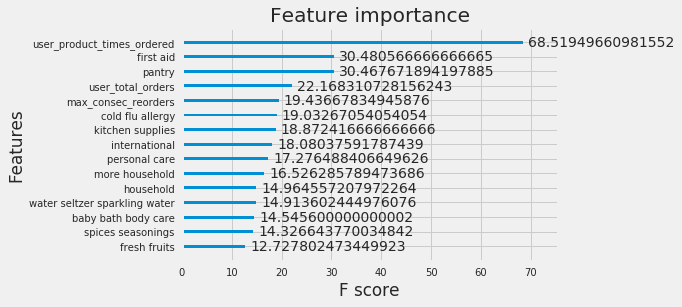

In [329]:
xgb.plot_importance(gbm, importance_type='gain', max_num_features=15)

In [47]:
df_X.in_cart.value_counts(normalize=True)

0    0.9022
1    0.0978
Name: in_cart, dtype: float64